# Analysis of The City of Toronto for opening a new Restaurant

##  Introduction/Business Problem

Let's say there is an investor who wants to start a new restaurant in Toronto. They are open to ideas of different cuisines or may even set up different cuisines in different areas to target the local market. What they want is an in-depth analysis of the City of Toronto and its neighborhoods. They want to know that what are the best places to start a restaurant business and what sort of cuisine would most likely to be a hit in that region. They also want to know that for each reccommended place, what are other similar places they can set up their restauraunts in.

## Data Sources

1) **Foursquare API** : As used previously, the foursquare API will be used to get data about Toronto and its neighborhood. This will help categorize neighborhoods by counting the frequency of the type of venues there are and see which neighborhoods in particular have more restaurants in their top 10 most common places. Also, we will use this data to segment similar neighborhoods together. Our client wants to know the best places to open their restaurant and the most similar places where they can expand their business or start a food chain. Through segmentation we can achieve this by choosing from the neighborhoods which are in the same cluster

2) **Toronto Opendata**: Foursquare API will only give us data about the most common categories of venues in the Neighborhoods. To gain more data about these neighborhoods, such as important economic indicators (Population, Income, Multicultrul Index, Ethnicity ratios) so we know our customer base and what sort of features of a restaurant like price ranges, cuisines, etc. would they be probably interested in. The data contains the postal codes/Neighborhood names which will allow me to merge the two data sets

3) **Yelp Dataset**: This is included as an extended part of my analysis. Through the yelp data (Downloaded as a json file from their website) I will generate data (Ratings, Cuisines, Price ranges, number of positive reviews) about restaurants in each neighborhood and once I have the best places based on the Foursquare and Opendata data, I will list down the famous restaurants in that place/neighborhood to give my client an idea about the market and my client's competitors. This dataset is quite large and potentially can generate a lot of useful features. I will try to utilize this data as much as I can within the given time constraint

## Methodology

### Business Understanding

Our client wants to perform a sort of market analysis of the neighborhoods of Toronto to help them determine what factors of a neighborhood drives the restaurant business in that nieghborhood, IF people in that neighborhood frequently visit restaurants. The client not only wants to analyze neighborhoods in isolation, but they want to find out information about their potential competition(s) in a particular neighborhood and see what sort of restaurants they are in terms of service, cuisine, timings and other defining attributes of a restaurant. Moreover, they want to forecast a mass initialization of a potential business by creating different branches in "similar" neighborhoods so they can target maximum audience in Toronto.

### Analytic Approach

The objective of the client will be achieved primarily with thorough analysis of the data at hand. The objective is not to predict a certain number or label but to suggest the best possible solution(s) i.e. Neighborhoods and their corresponding restaurant types. However, the client does require to accumalate similar neighborhoods together to see Toronto in a more granular form so they can open multiple branches, for this purpose we will need a form of unsuprervised learning to segment Toronto into similar neighborhoods based on the features of each neighborhood. So, we will be using clustering to group similar neighborhoods together.

### Data Requirements

In order to carry out this market research, we will be first needing sufficient data about the neighborhoods of Toronto which will contain their geospatial data, demographics and important economic indicators. Next, we will be needing data about the local businesses in each of these neighborhoods and details about these businesses like their popularity, their cuisine, timings as well as geospatial data.

### Data Collection, Preperation and Cleaning

In [0]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
import json
from pandas.io.json import json_normalize
from shapely.geometry import shape, Point
import matplotlib.pyplot as plt
import seaborn as sns

#### Toronto Opendata

In this section, we will be collecting, cleaning and preparing data from Toronto's Opendata portal. Two datasets from the portal have been used:  
1) Neighborhood Boundaries: Contains the geojson file with all boundaries of each neighborhood  
2) Neighborhood Profile: Contains in depth demographics of each neighborhood  
https://open.toronto.ca/catalogue/

I will first use the geojson file to create a dataframe consisting of neighborhoods and their longitudes and latitudes. The entire geojson file will be later used to create choropleth maps

In [0]:
geojson_data = None
with open(base_dir+'Neighbourhoods.geojson') as f:
    geojson_data = json.load(f)

In [0]:
toronto_data = json_normalize(geojson_data['features'])

In [0]:
toronto_data.head()

,geometry.coordinates,geometry.type,properties.AREA_ATTR_ID,properties.AREA_DESC,properties.AREA_ID,properties.AREA_LONG_CODE,properties.AREA_NAME,properties.AREA_SHORT_CODE,properties.LATITUDE,properties.LONGITUDE,properties.OBJECTID,properties.PARENT_AREA_ID,properties.Shape__Area,properties.Shape__Length,properties.X,properties.Y,properties._id,type
0,"[[[-79.43591570873059, 43.68015339477487], [-7...",Polygon,25926662,Wychwood (94),25886861,94,Wychwood (94),94,43.676919,-79.425515,16491505,49885,3.217960e+06,7515.779658,None,None,281,Feature
1,"[[[-79.41095783825973, 43.704082823014815], [-...",Polygon,25926663,Yonge-Eglinton (100),25886820,100,Yonge-Eglinton (100),100,43.704689,-79.403590,16491521,49885,3.160334e+06,7872.021074,None,None,282,Feature
2,"[[[-79.39119482591805, 43.68108112277795], [-7...",Polygon,25926664,Yonge-St.Clair (97),25886834,97,Yonge-St.Clair (97),97,43.687859,-79.397871,16491537,49885,2.222464e+06,8130.411276,None,None,283,Feature
3,"[[[-79.50528791818931, 43.759873498780955], [-...",Polygon,25926665,York University Heights (27),25886593,27,York University Heights (27),27,43.765736,-79.488883,16491553,49885,2.541821e+07,25632.335242,None,None,284,Feature
4,"[[[-79.4396873322608, 43.70560981891119], [-79...",Polygon,25926666,Yorkdale-Glen Park (31),25886688,31,Yorkdale-Glen Park (31),31,43.714672,-79.457108,16491569,49885,1.156669e+07,13953.408098,None,None,285,Feature


By using json_normalize() we have flattened out the geojson file and created a pandas Dataframe from it

In [0]:
toronto_data = toronto_data[['properties.AREA_NAME','properties.LONGITUDE','properties.LATITUDE']]
toronto_data.columns = ['Geojson Key','Longitude','Latitude']
toronto_data.head()

,Geojson Key,Longitude,Latitude
0,Wychwood (94),-79.425515,43.676919
1,Yonge-Eglinton (100),-79.403590,43.704689
2,Yonge-St.Clair (97),-79.397871,43.687859
3,York University Heights (27),-79.488883,43.765736
4,Yorkdale-Glen Park (31),-79.457108,43.714672


The AREA_NAME contains the area code along with the neighborhood name in parenthesis, so let's remove that and just store the neighborhood name

In [0]:
toronto_data['Neighborhood'] = toronto_data['Geojson Key'].apply(lambda x: x.split('(')[0] )
columns = [list(toronto_data.columns)[-1] ] + list(toronto_data.columns)[:-1]
toronto_data = toronto_data[columns]
toronto_data =toronto_data.sort_values('Neighborhood').reset_index(drop=True)

In [0]:
toronto_data.head()

,Latitude,Neighborhood,Geojson Key,Longitude
0,43.805441,Agincourt North,Agincourt North (129),-79.266712
1,43.788658,Agincourt South-Malvern West,Agincourt South-Malvern West (128),-79.265612
2,43.604937,Alderwood,Alderwood (20),-79.541611
3,43.671585,Annex,Annex (95),-79.404001
4,43.737657,Banbury-Don Mills,Banbury-Don Mills (42),-79.349718


The resulting Dataframe consists of only the neighborhoods, their longitudes and latitudes and I have retained the original neighborhood name with area code so I can later use it to key on the choropleth map

Now I will be using the neighborhood profiles dataset to add representative features to each neighborhood

In [0]:
neighborhood_profiles = pd.read_csv('./neighborhood_profiles.csv')
neighborhood_profiles = neighborhood_profiles.drop(['_id','City of Toronto','Data Source'],1)
neighborhood_profiles = neighborhood_profiles.set_index(['Category','Topic','Characteristic'])
neighborhood_profiles = neighborhood_profiles.T
neighborhood_profiles.sort_index(inplace=True)
# print(list(neighborhood_profiles.loc['Category']))
# neighborhood_profiles.drop(list(neighborhood_profiles.columns[:944]),axis=1,inplace=True) # Drop Population info
# neighborhood_profiles['Income']['Income of individuals in 2015'].columns
neighborhood_profiles.head()

Category                     Neighbourhood Information                       \
Topic                        Neighbourhood Information                        
Characteristic                    Neighbourhood Number TSNS2020 Designation   
Agincourt North                                    129       No Designation   
Agincourt South-Malvern West                       128       No Designation   
Alderwood                                           20       No Designation   
Annex                                               95       No Designation   
Banbury-Don Mills                                   42       No Designation   

Category                                   Population                   \
Topic                        Population and dwellings                    
Characteristic                       Population, 2016 Population, 2011   
Agincourt North                                29,113           30,279   
Agincourt South-Malvern West                   23,757           21,988   
Alderwood                                      12,054           11,904   
Annex                                          30,526           29,177   
Banbury-Don Mills                              27,695           26,918   

Category                                                  \
Topic                                                      
Characteristic               Population Change 2011-2016   
Agincourt North                                   -3.90%   
Agincourt South-Malvern West                       8.00%   
Alderwood                                          1.30%   
Annex                                              4.60%   
Banbury-Don Mills                                  2.90%   

Category                                              \
Topic                                                  
Characteristic               Total private dwellings   
Agincourt North                                9,371   
Agincourt South-Malvern West                   8,535   
Alderwood                                      4,732   
Annex                                         18,109   
Banbury-Don Mills                             12,473   

Category                                                                    \
Topic                                                                        
Characteristic               Private dwellings occupied by usual residents   
Agincourt North                                                      9,120   
Agincourt South-Malvern West                                         8,136   
Alderwood                                                            4,616   
Annex                                                               15,934   
Banbury-Don Mills                                                   12,124   

Category                                                              \
Topic                                                                  
Characteristic               Population density per square kilometre   
Agincourt North                                                3,929   
Agincourt South-Malvern West                                   3,034   
Alderwood                                                      2,435   
Annex                                                         10,863   
Banbury-Don Mills                                              2,775   

Category                                                     \
Topic                                                         
Characteristic               Land area in square kilometres   
Agincourt North                                        7.41   
Agincourt South-Malvern West                           7.83   
Alderwood                                              4.95   
Annex                                                  2.81   
Banbury-Don Mills                                      9.98   

Category                                                     ...            \
Topic                          Age characteristics         

The dataset contains multiple layers of features which define very fine grained characteristics of each neighborhood. Consequently, it has **2383** which are too much to analyze manually. Feature selection for this dataset will take considerable time but due to the urgency of the deliverable, we will only be looking at a handful of features from these 2383 features. The process of feature selection was a hit and trial method, where I traversed the multi-indexed columns of the dataframe and selected some representative features.

Before even looking at the columns, I was interested in the population of each neighborhood. In light of the business problem, the client would need to know how dense the population of a certain area is therefore increasing the chances gaining more customers. The population column itself had multiple sub topics and characteristics and thus I wanted to find a feature that would summarize the population information for me. I ended up choosing the population density metric

In [0]:
population = neighborhood_profiles['Population']['Population and dwellings']['Population density per square kilometre']
population = population.to_frame()
population = population.reset_index()
population.columns = ['Neighborhood','Population Density per sq. km']
population['Population Density per sq. km'] = population['Population Density per sq. km'].apply(lambda string: string.strip().replace(',',''))
population['Population Density per sq. km'] = population['Population Density per sq. km'].apply(pd.to_numeric)
population.to_csv('./populati')
population.head()

,Neighborhood,Population Density per sq. km
0,Agincourt North,3929
1,Agincourt South-Malvern West,3034
2,Alderwood,2435
3,Annex,10863
4,Banbury-Don Mills,2775


Another metric, I was interested in was the overall income of each neighborhood so I can categorize each neighborhood based on the income of its inhabitants. This feature will allow us to examine our customer base and figure out what price range should be set for the client's product which will be affordable for the clients. There were multiple metrics like income of individuals, income before tax, after tax etc but keeping our theme of using granular data, I used Income of households in 2015 which was the most recent metric and was a reasonable summary metric for income of a neighborhood

In [0]:
list(neighborhood_profiles['Income']['Income of households in 2015'].columns)[-20:]

['Total - Household after-tax income groups in 2015 for private households - 100% data',
 '  Under $5,000',
 '  $5,000 to $9,999',
 '  $10,000 to $14,999',
 '  $15,000 to $19,999',
 '  $20,000 to $24,999',
 '  $25,000 to $29,999',
 '  $30,000 to $34,999',
 '  $35,000 to $39,999',
 '  $40,000 to $44,999',
 '  $45,000 to $49,999',
 '  $50,000 to $59,999',
 '  $60,000 to $69,999',
 '  $70,000 to $79,999',
 '  $80,000 to $89,999',
 '  $90,000 to $99,999',
 '  $100,000 and over',
 '    $100,000 to $124,999',
 '    $125,000 to $149,999',
 '    $150,000 to $199,999']

We can see the categories the organization that collected this data had made to represent everyone. But since these are still too many columns and each column contained the number of housholds that fall in a specific category. I decided the further accumalate the data and assign each neighborhood the category which had the most number of households in it. This gives us the majority income of that neighborhood

In [0]:
incomes = neighborhood_profiles['Income']['Income of households in 2015'][ [  '  Under $5,000',
 '  $5,000 to $9,999',
 '  $10,000 to $14,999',
 '  $15,000 to $19,999',
 '  $20,000 to $24,999',
 '  $25,000 to $29,999',
 '  $30,000 to $34,999',
 '  $35,000 to $39,999',
 '  $40,000 to $44,999',
 '  $45,000 to $49,999',
 '  $50,000 to $59,999',
 '  $60,000 to $69,999',
 '  $70,000 to $79,999',
 '  $80,000 to $89,999',
 '  $90,000 to $99,999', '    $100,000 to $124,999', '    $125,000 to $149,999' ] ]
incomes = incomes.apply(lambda col: col.apply(lambda string: string.strip().replace(',','') ))
incomes = incomes.apply(pd.to_numeric)
majority_incomes = incomes.idxmax(axis=1).to_frame()
majority_incomes.columns = ['Majority Income']
majority_incomes['Majority Income'].apply(str)
majority_incomes['Majority Income'].unique()

array(['    $100,000 to $124,999', '  $50,000 to $59,999',
       '  Under $5,000', '  $15,000 to $19,999', '  $10,000 to $14,999'], dtype=object)

After assigning the majority category, I viewed the unique categories that have been assigned. I still felt there were many categories and in order to ease visualizations and inference, I transformed these categories into High, Medium and Low.  
High: Contains the 100,000$+ range because that is obviously the outlier amongst the list
Medium: Contains 50-60,000$
Low: Contains the remaing groups, these were all accumulated since these groups were comparable but considerably lower than the other two ranges

In [0]:
majority_incomes['Majority Income'].replace(to_replace={'    $100,000 to $124,999' : "High", '  $50,000 to $59,999' : "Medium", '  Under $5,000' : "Low", '  $15,000 to $19,999' : "Low", '  $10,000 to $14,999' : "Low" }, inplace=True)
majority_incomes['Majority Income'].value_counts()

High      75
Medium    55
Low       10
Name: Majority Income, dtype: int64

We can see that most of the neighborhoods contain a majority of high or medium income households. There are only a few neighborhood with a majority low income households

Since we are interested in setting up a restaurant, I thought it would be interesting to see the majority ethnicity of each neighborhood which will give more information about the majority customer base in a neighborhood and may even hint at a preferred cuisine in a neighborhood

In [0]:
ethnic_population = neighborhood_profiles['Ethnic origin']['Ethnic origin population']
ethnic_population = ethnic_population.apply(lambda col: col.apply(lambda string: string.strip().replace(',','') ))
ethnic_population = ethnic_population.apply(pd.to_numeric)
drop_columns = ['Total - Ethnic origin for the population in private households - 25% sample data'] +  [col for col in ethnic_population.columns if 'origins' in col.lower() ]
# print(drop_columns)
ethnic_population.drop(drop_columns,axis=1,inplace=True)
# list(ethnic_population.columns)
majority_ethnicity = ethnic_population.idxmax(axis=1).to_frame()
majority_ethnicity.columns = ['Majority Ethnicity']
majority_ethnicity['Majority Ethnicity'].value_counts()

 English        50
 Chinese        23
 Canadian       14
 Italian        13
 East Indian    11
 Filipino       11
 Portuguese      9
 Polish          2
 Bangladeshi     2
 Jamaican        2
 Pakistani       1
 Vietnamese      1
 Somali          1
Name: Majority Ethnicity, dtype: int64

Almost half of the neighborhoods have people of English ethnicity and that makes sense, because Toronto though being a cultural hub is an English-speaking country after all

In [0]:
majority_ethnicity.reset_index(level=0, inplace=True)

In [0]:
majority_ethnicity.columns = ['Neighborhood','Majority Ethnicity']
majority_ethnicity.head()

,Neighborhood,Majority Ethnicity
0,Agincourt North,Chinese
1,Agincourt South-Malvern West,Chinese
2,Alderwood,English
3,Annex,English
4,Banbury-Don Mills,Chinese


In [0]:
majority_incomes.reset_index(level=0, inplace=True)

In [0]:
majority_incomes.columns = ['Neighborhood','Majority Income']
majority_incomes.head()

,Neighborhood,Majority Income
0,Agincourt North,High
1,Agincourt South-Malvern West,Medium
2,Alderwood,High
3,Annex,High
4,Banbury-Don Mills,Medium


Finally, we merged all these features to create a dataframe representing the neighborhoods in toronto

In [0]:
toronto_majority_merged = pd.merge(majority_incomes,majority_ethnicity,on='Neighborhood',copy=True,how='inner')

In [0]:
toronto_majority_merged['Neighborhood'] = toronto_majority_merged['Neighborhood'].apply(str.strip)
toronto_data['Neighborhood'] = toronto_data['Neighborhood'].apply(str.strip)

In [0]:
toronto_data_merged = pd.merge(toronto_data,toronto_majority_merged,on='Neighborhood',copy=True)
toronto_data_merged = toronto_data_merged.dropna()

In [0]:
# toronto_data_merged.to_csv('./toronto_data_')
toronto_data_merged.head()

,Latitude,Neighborhood,Geojson Key,Longitude,Majority Income,Majority Ethnicity
0,43.805441,Agincourt North,Agincourt North (129),-79.266712,High,Chinese
1,43.788658,Agincourt South-Malvern West,Agincourt South-Malvern West (128),-79.265612,Medium,Chinese
2,43.604937,Alderwood,Alderwood (20),-79.541611,High,English
3,43.671585,Annex,Annex (95),-79.404001,High,English
4,43.737657,Banbury-Don Mills,Banbury-Don Mills (42),-79.349718,Medium,Chinese


The resulting table is a concise dataframe representing each neighborhood

Let's comment on the overall quality of the datasets obtained from Toronto Opendata portal.

1. **Completeness**: The dataset has no missing values
2. **Uniqueness**: No neighborhood has been replicated
3. **Timeliness**: The geospatial data is going to remain the same for the city. For the neighborhood profiles data, it was a survey of 2015 which is a couple of years old but still valid since a drastic change in demographics is highly unlikely
4. **Validity**: The data had inconsistencies with the type of attributes, for instance, the population density should be a numeric but was a string so there were similar inconsistencies within the format which had to be dealt with.
5. **Accuracy**: Again, the survey was conducted by government professionals, indicating its accurate
6. **Consistency**: Data was consistent as both datasets from the portal had the same names for the neighborhoods and contained 140 neighborhoods

#### Using the Yelp Dataset

Since the client also requires an overview of the potential competition in the market, we will need data for the current restaurants in each neighborhood. I could've used the Foursquare API for this, but due to the limited number of tips and reviews per day, I decided to go with the yelp dataset provided by yelp for their dataset challenge. This will contain much more comprehensive data for each restaurant which will make our analysis more accurate

In [0]:
yelp_business = pd.read_csv('./datasets/yelp_dataset/business.csv',low_memory=False)
yelp_business.head()

,attributes.Music,review_count,attributes.RestaurantsAttire,state,hours.Tuesday,business_id,hours,categories,attributes.DietaryRestrictions,attributes.BusinessAcceptsCreditCards,...,longitude,attributes.BusinessParking,attributes.HasTV,attributes.BYOB,postal_code,attributes.BusinessAcceptsBitcoin,attributes.CoatCheck,attributes.Caters,attributes.BYOBCorkage,is_open
0,NaN,5,NaN,AZ,NaN,1SWheh84yJXfytovILXOAQ,NaN,"Golf, Active Life",NaN,NaN,...,-112.018481,NaN,NaN,NaN,85016,NaN,NaN,NaN,NaN,0
1,NaN,128,u'casual',ON,9:0-0:0,QXAEGFB4oINsVuTFxEYKFQ,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...","Specialty Food, Restaurants, Dim Sum, Imported...",NaN,NaN,...,-79.652289,"{'garage': False, 'street': False, 'validated'...",False,NaN,L5R 3E7,NaN,NaN,True,NaN,1
2,NaN,170,'casual',NC,NaN,gnKjwL_1w79qoiV3IC_xQQ,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...","Sushi Bars, Restaurants, Japanese",NaN,True,...,-80.859132,"{'garage': False, 'street': False, 'validated'...",True,NaN,28210,NaN,NaN,False,NaN,1
3,NaN,3,NaN,AZ,8:0-17:0,xvX2CttrVhyG2z1dFg_0xw,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...","Insurance, Financial Services",NaN,NaN,...,-112.395596,NaN,NaN,NaN,85338,NaN,NaN,NaN,NaN,1
4,NaN,4,NaN,NC,7:0-23:0,HhyxOkGAM07SRYtlQ4wMFQ,"{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...","Plumbing, Shopping, Local Services, Home Servi...",NaN,True,...,-80.887223,NaN,NaN,NaN,28217,False,NaN,NaN,NaN,1


In [0]:
yelp_business.shape

(192609, 60)

The yelp dataset contains information about 192,609 businesses across the world. Let's narrow it down to businesses in Toronto and more specifically food businesses/restaurants only

In [0]:
toronto_yelp_data = yelp_business[(yelp_business['city'] == 'Toronto') | (yelp_business['city'] == 'toronto')]
toronto_yelp_data = toronto_yelp_data.dropna(subset = ['categories'])
toronto_yelp_data['categories'].isnull().values.any()

False

In [0]:
toronto_restaurants = toronto_yelp_data[toronto_yelp_data['categories'].str.contains('Restaurants') ]
toronto_restaurants.head()

,attributes.Music,review_count,attributes.RestaurantsAttire,state,hours.Tuesday,business_id,hours,categories,attributes.DietaryRestrictions,attributes.BusinessAcceptsCreditCards,...,longitude,attributes.BusinessParking,attributes.HasTV,attributes.BYOB,postal_code,attributes.BusinessAcceptsBitcoin,attributes.CoatCheck,attributes.Caters,attributes.BYOBCorkage,is_open
29,NaN,57,NaN,ON,8:0-21:0,NDuUMJfrWk52RA-H-OtrpA,"{'Monday': '8:0-21:0', 'Tuesday': '8:0-21:0', ...","Juice Bars & Smoothies, Food, Restaurants, Fas...",NaN,NaN,...,-79.425429,"{'garage': False, 'street': True, 'validated':...",NaN,NaN,M6J 1J5,NaN,NaN,False,NaN,1
32,NaN,29,u'casual',ON,9:0-18:0,SP_YXIEwkFPPl_9anCYmpQ,"{'Tuesday': '9:0-18:0', 'Wednesday': '9:0-18:0...","Restaurants, Nightlife, Breakfast & Brunch, Ve...",NaN,NaN,...,-79.432099,"{'garage': False, 'street': True, 'validated':...",False,NaN,M6H 1M4,NaN,NaN,True,NaN,0
50,"{'dj': False, 'background_music': False, 'no_m...",9,'dressy',ON,NaN,mlHC2XcU9Bows6cnYEmRgg,"{'Thursday': '18:0-2:0', 'Friday': '18:0-2:0',...","Restaurants, Breakfast & Brunch, Bars, Modern ...",NaN,NaN,...,-79.413352,"{'garage': False, 'street': True, 'validated':...",False,NaN,M6G 1B3,NaN,False,False,NaN,0
83,NaN,18,u'casual',ON,NaN,RFbMVekR8lU9tPJ8sWrwHg,NaN,"Italian, Restaurants",NaN,NaN,...,-79.388230,"{'garage': False, 'street': True, 'validated':...",False,NaN,M4S 2M5,NaN,NaN,NaN,NaN,1
96,NaN,43,u'casual',ON,11:0-23:0,NPHZkn1e-tSJAbo8Zm9rYw,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...","Tex-Mex, Mexican, Restaurants",NaN,NaN,...,-79.316468,"{'garage': False, 'street': True, 'validated':...",False,NaN,M4L 1G4,NaN,NaN,False,NaN,1


In [0]:
toronto_restaurants = toronto_restaurants.dropna(how='all',axis=1)
restaurants_location = toronto_restaurants[['review_count','business_id','name','postal_code','address','longitude','latitude']]
restaurants_location.head()

,review_count,business_id,name,postal_code,address,longitude,latitude
29,57,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,M6J 1J5,1170 Queen Street W,-79.425429,43.642889
32,29,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,M6H 1M4,1051 Bloor Street W,-79.432099,43.660494
50,9,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,M6G 1B3,582 College Street,-79.413352,43.655420
83,18,RFbMVekR8lU9tPJ8sWrwHg,Tavolino,M4S 2M5,619 Mount Pleasant Road,-79.388230,43.704229
96,43,NPHZkn1e-tSJAbo8Zm9rYw,Burrito Bandidos,M4L 1G4,1614 Queen Street E,-79.316468,43.666181


The review count contains the number of reviews present for each business. In order to make our analysis more generic, we will discard businesses which have low review counts as we cannot properly evaluate the performance of a business due to lack of data. We only keep the businesses which have above the average number of review counts

In [0]:
restaurants_location['review_count'].describe()

count    7964.000000
mean       46.009794
std        82.675558
min         3.000000
25%         7.000000
50%        18.000000
75%        51.000000
max      2121.000000
Name: review_count, dtype: float64

In [0]:
restaurants_location = restaurants_location[restaurants_location['review_count'] > 46]
restaurants_location.head()

,review_count,business_id,name,postal_code,address,longitude,latitude
29,57,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,M6J 1J5,1170 Queen Street W,-79.425429,43.642889
159,332,c35qzLN6ItDpVIoj2uQW4Q,Ravi Soups,M5V 1R1,322 Adelaide Street W,-79.392032,43.647585
293,72,iyPtSR0s6EkvaQFbdJ_jVA,Pearl King,M5V 1J5,291 King Street W,-79.390019,43.646478
453,47,43PeF0ERpSIiEbXM6f9N2g,Megas Restaurant,M4K 1P3,402 Danforth Avenue,-79.351577,43.677757
529,122,h_ypoQ2rmwX8UGSmohsGiQ,Maman,M5X 1C1,"1 First Canadian Place, Food Terrace, Upper Level",-79.382409,43.648977


In [0]:
restaurants_location.shape

(2151, 7)

We now have basic information about 2151 restaurants in Toronto. We will later add more tables to get more information about a business. The reason I have not maintained one large dataframe consisting of all the features is for the sake of clarity.

In [0]:
def getNeighborhood(long,lat,geojson_data,geojson_path='./Neighbourhoods.geojson',):
    point = Point(long, lat) 	

    # check each polygon to see if it contains the point
    for feature in geojson_data['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            neighborhood = feature['properties']['AREA_NAME']
            return neighborhood.split(' (')[0]
    return 'NULL'

Now we will add additional information for each business. Let's start with the most obvious one, i.e. assigning a business a neighborhood based on its address

In [0]:
neighborhood_labels = restaurants_location.apply(lambda row: getNeighborhood(row['longitude'],row['latitude'],geojson_data) ,axis=1)
neighborhood_labels.shape

(2151,)

In [0]:
restaurants_location['Neighborhood'] = neighborhood_labels
restaurants_location.dropna(subset=['Neighborhood'],inplace=True)

Let's see if any restaurant has not been assigned a neighborhood.

In [0]:
restaurants_location[restaurants_location['Neighborhood'] == 'NULL']

,review_count,business_id,name,postal_code,address,longitude,latitude,Neighborhood
9874,50,6hnRhJv7O0RgvFT-BIo0KA,Ten Ren's Tea,M6A 2T9,"Smart Center Plaza, 1070 Major Mackenize Drive E",-79.411563,43.876501,NULL
90736,89,ebVPLAeD7FZ2VzY5ryOCxw,Eli's Table,L6A 4J3,"9421 Jane St, Unit 123",-79.533506,43.836467,NULL
103752,47,Sc08tWE2M0HktBuUC_Ve0A,Molson Pub,L5P 1B2,"Pearson International Airport, 3111 Convair Drive",-79.616614,43.659532,NULL


Although there are only three restaurants that have not been assigned a neighborhood. Let's see if we can assign them an appropriate neighborhood manually

In [0]:
restaurants_location = restaurants_location[restaurants_location['Neighborhood'] != 'NULL']
# restaurants_location.head()

In [0]:
P = list(restaurants_location['Neighborhood'].unique())
Q = list(toronto_data_merged['Neighborhood'].unique())

R = [el for el in P if el not in Q]
# print(len(P))
# len(R)
R

['Cabbagetown-South St.James Town',
 'North St.James Town',
 'Mimico',
 'Weston-Pellam Park']

So these are the neighborhoods which are not in our Neighborhood data. Let's see how many businesses they have

In [0]:
restaurants_location[restaurants_location['Neighborhood'].isin(R)]

,review_count,business_id,name,postal_code,address,longitude,latitude,Neighborhood
43440,52,exs56JDSWmPWQ3dQOdjHag,Kibo Sushi House,M4X 1P3,533 Parliament Street,-79.368303,43.665654,Cabbagetown-South St.James Town
46594,104,MLQeuiL9rqOq_rDKGEcU0A,F'Amelia,M4X 1E1,12 Amelia Street,-79.368672,43.667526,Cabbagetown-South St.James Town
48784,338,G24p1oGGfY3t-m8Z2lPCaQ,Tinuno,M4X 1J6,31 Howard Street,-79.374853,43.671143,North St.James Town
50713,119,1nQMj-F3Oz3IeP9h10CNIA,The Blake House,M4Y 2G6,449 Jarvis Street,-79.377156,43.664492,Cabbagetown-South St.James Town
52210,79,Ado3kudEn4uApQBWFCqWLA,Chew Chew's Diner,M5A 2K6,186 Carlton Street,-79.372287,43.663489,Cabbagetown-South St.James Town
60329,71,Ehln9m65hoi5ylWCH2osdQ,Tich Modern Indian Cuisine,M8V 1B5,2314 Lakeshore Boulevard W,-79.487238,43.617594,Mimico
79218,56,GmdNtIDYsdxa4Ph0eQoj_A,St Clair Banh Cuon Pho Ga,M6N 1J3,1772 Saint Clair Avenue W,-79.461314,43.674073,Weston-Pellam Park
80359,154,abO4gvGKB0aVjsrXHlgeFg,Nobuya,M8V 2W1,285 Royal York Road,-79.497516,43.614481,Mimico
81803,65,yx4SuEdloQxr5FR4XcNaTg,Johnny G's,M4X 1P2,478 Parliament Street,-79.368234,43.664531,Cabbagetown-South St.James Town
85906,397,nqTvE7ivdU23oUWdI01tOA,Under The Table Restaurant,M4X 1P8,568 Parliament Street,-79.369456,43.667423,Cabbagetown-South St.James Town


Since there are a lot of restaurants in these neighborhoods, we will need to cater them and include them in our analysis. We search for 'similar' names in our neighborhood dataframe and assign the missing restaurants those neighborhoods. Note that for the case of Mimico, it was not found at all in our dataframe so I googled and found out it falls in the Etobicoke area.

In [0]:
toronto_data_merged[toronto_data_merged['Neighborhood'].str.contains('Weston')]

,Latitude,Neighborhood,Geojson Key,Longitude,Majority Income,Majority Ethnicity
123,43.702716,Weston,Weston (113),-79.515723,Medium,Jamaican


In [0]:
toronto_data_merged[toronto_data_merged['Neighborhood'].str.contains('James')]

,Latitude,Neighborhood,Geojson Key,Longitude,Majority Income,Majority Ethnicity
79,43.746868,Mount Olive-Silverstone-Jamestown,Mount Olive-Silverstone-Jamestown (2),-79.587259,Medium,East Indian


In [0]:
toronto_data_merged[toronto_data_merged['Neighborhood'].str.contains('Etobicoke')] #Searched google. Mimico falls in Etobicoke

,Latitude,Neighborhood,Geojson Key,Longitude,Majority Income,Majority Ethnicity
40,43.645063,Etobicoke West Mall,Etobicoke West Mall (13),-79.568939,Medium,English


In [0]:
## TODO: REPLACE NEIGHBORHOOD VALUES IN RESTAURANT LOCATION FROM CORRESNPONDING TORONTO DATA MERGED VALUE
replace_values = {
    'Cabbagetown-South St.James Town' : 'Mount Olive-Silverstone-Jamestown',
    'North St.James Town' : 'Mount Olive-Silverstone-Jamestown',
    'Weston-Pellam Park' : 'Weston',
    'Mimico' : 'Etobicoke West Mall'
}
restaurants_location['Neighborhood'] = restaurants_location['Neighborhood'].replace(replace_values)

Double checking if there are any more unassigned neighborhoods

In [0]:
P = list(restaurants_location['Neighborhood'].unique())
Q = list(toronto_data_merged['Neighborhood'].unique())

R = [el for el in P if el not in Q]
R

[]

In [0]:
restaurants_location.head()

,review_count,business_id,name,postal_code,address,longitude,latitude,Neighborhood
29,57,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,M6J 1J5,1170 Queen Street W,-79.425429,43.642889,Little Portugal
159,332,c35qzLN6ItDpVIoj2uQW4Q,Ravi Soups,M5V 1R1,322 Adelaide Street W,-79.392032,43.647585,Waterfront Communities-The Island
293,72,iyPtSR0s6EkvaQFbdJ_jVA,Pearl King,M5V 1J5,291 King Street W,-79.390019,43.646478,Waterfront Communities-The Island
453,47,43PeF0ERpSIiEbXM6f9N2g,Megas Restaurant,M4K 1P3,402 Danforth Avenue,-79.351577,43.677757,Playter Estates-Danforth
529,122,h_ypoQ2rmwX8UGSmohsGiQ,Maman,M5X 1C1,"1 First Canadian Place, Food Terrace, Upper Level",-79.382409,43.648977,Bay Street Corridor


Now that we have basic information about each restaurant to work with. Let's create tables so we can reference them later to get more details about a business we're interested in. The yelp dataset mainly contains the 'Hours' features which tell about the Weekly hours of a restaurant and 'Attributes' which contain all the important attributes of a restaurant

In [0]:
restaurants_details = toronto_restaurants.copy()
hours_columns = ['business_id', 'name'] + [el for el in list(restaurants_details.columns) if 'hours' in el and el != 'hours']
# hours_columns

In [0]:
attributes_columns = ['business_id', 'name'] + [el for el in list(restaurants_details.columns) if 'attributes' in el and el != 'attributes']
# attributes_columns

In [0]:
restaurant_hours = restaurants_details[hours_columns].copy()
restaurant_hours.dropna(inplace=True)
restaurant_hours.columns = [el.split('.')[1] if '.' in el else el for el in restaurant_hours.columns]
restaurant_hours = restaurant_hours[['business_id','name','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
# restaurant_hours.to_csv('./restaurant_hours.csv',index=False)
restaurant_hours.head()

,business_id,name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
29,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,8:0-21:0,8:0-21:0,8:0-21:0,8:0-21:0,8:0-21:0,9:0-21:0,9:0-21:0
96,NPHZkn1e-tSJAbo8Zm9rYw,Burrito Bandidos,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,12:0-23:0,12:0-22:0
116,gyFYZV4b_9TxG1ulQNi0Ig,Paramount Fine Foods,10:0-22:0,10:0-22:0,10:0-22:0,10:0-22:0,10:0-23:0,10:0-23:0,10:0-22:0
119,OezwOIJ0_62Mj8MLdkGRAw,Aroma Espresso Bar,7:0-23:0,7:0-23:0,7:0-23:0,7:0-23:0,7:0-23:0,8:0-19:0,8:0-19:0
121,aql8K6zVoJDGRJ3P-IgtpQ,Ume Fashion Sushi,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,14:0-22:0,14:0-22:0


In [0]:
restaurant_attributes = restaurants_details[attributes_columns].copy()
restaurant_attributes.columns = [el.split('.')[1] if '.' in el else el for el in restaurant_attributes.columns]
restaurant_attributes.dropna(axis=1,inplace=True,how='all')
restaurant_attributes.to_csv('./restaurant_attributes.csv',index=False)
restaurant_attributes.head()

,business_id,name,Music,RestaurantsAttire,DietaryRestrictions,BusinessAcceptsCreditCards,GoodForMeal,BikeParking,RestaurantsCounterService,NoiseLevel,...,HairSpecializesIn,RestaurantsGoodForGroups,WiFi,RestaurantsReservations,AgesAllowed,BusinessParking,HasTV,BusinessAcceptsBitcoin,CoatCheck,Caters
29,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,...,NaN,NaN,u'no',NaN,NaN,"{'garage': False, 'street': True, 'validated':...",NaN,NaN,NaN,False
32,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,NaN,u'casual',NaN,NaN,NaN,True,NaN,u'average',...,NaN,True,u'free',True,NaN,"{'garage': False, 'street': True, 'validated':...",False,NaN,NaN,True
50,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,"{'dj': False, 'background_music': False, 'no_m...",'dressy',NaN,NaN,"{'dessert': False, 'latenight': False, 'lunch'...",True,NaN,NaN,...,NaN,True,u'free',True,NaN,"{'garage': False, 'street': True, 'validated':...",False,NaN,False,False
83,RFbMVekR8lU9tPJ8sWrwHg,Tavolino,NaN,u'casual',NaN,NaN,"{'dessert': False, 'latenight': False, 'lunch'...",True,NaN,u'quiet',...,NaN,True,NaN,True,NaN,"{'garage': False, 'street': True, 'validated':...",False,NaN,NaN,NaN
96,NPHZkn1e-tSJAbo8Zm9rYw,Burrito Bandidos,NaN,u'casual',NaN,NaN,NaN,True,NaN,u'average',...,NaN,True,u'no',False,NaN,"{'garage': False, 'street': True, 'validated':...",False,NaN,NaN,False


Although there are 37 attributes per restaurant, most of the data is sparse i.e. contains a lot of missing values. The reason I have not removed these NaN values is that when we come back to use this table to get more information about a restaurant, we want to get the maximum number of defined attributes we can get. And since there is no trend in the missing values, we cannot remove them all. The only exception were those columns that had missing values for **each** restaurant

Now we will make use of the Reviews dataset provided by Yelp. It contains all reviews posted by users for businesses. Since the dataset was very large to fit in memory. I processed the dataset in chunks and **ONLY** kept those records which contained reviews about the businesses within Toronto and more specifically within my restaurant data table

In [0]:
b_ids = list(restaurants_location['business_id'])

In [0]:
# num_of_rows = 1024
# TextFileReader = pd.read_csv('./datasets/yelp_dataset/review.csv', chunksize=num_of_rows)

# dfs = []
# for chunk_df in TextFileReader:
#     chunk_df = chunk_df[chunk_df['business_id'].isin(b_ids)]
#     dfs.append(chunk_df)
# df = pd.concat(dfs,sort=False)

In [0]:
# df.to_csv('./Toronto_restaurants_reviews.csv')

In [0]:
# restaurant_reviews = df.copy()
restaurant_reviews = pd.read_csv('./Toronto_restaurants_reviews.csv')
# restaurant_reviews.to_csv('./Toronto_restaurants_reviews.csv',index=False)
restaurant_reviews.head()

,stars,review_id,date,useful,text,user_id,funny,cool,business_id
0,1.0,JVcjMhlavKKn3UIt9p9OXA,2012-07-16 00:37:14,1,I cannot believe how things have changed in 3 ...,TpyOT5E16YASd7EWjLQlrw,1,0,AakkkTuGZA2KBodKi2_u8A
1,5.0,svK3nBU7Rk8VfGorlrN52A,2017-04-07 21:27:49,0,You can't really find anything wrong with this...,NJlxGtouq06hhC7sS2ECYw,0,0,YvrylyuWgbP90RgMqZQVnQ
2,3.0,4bUyL7lzoWzDZaJETAKREg,2014-06-27 21:19:23,0,Good selection of classes of beers and mains. ...,_N7Ndn29bpll_961oPeEfw,0,0,y-Iw6dZflNix4BdwIyTNGA
3,1.0,E6B-2U2sGG3xgmnNWZAEew,2017-12-29 13:55:19,0,Came here on a Thursday night at 6:30 p.m. My ...,DbccYu3OppWKl21OanZnTg,0,0,YSUcHqlKMPHHJ_cTrqtNrA
4,4.0,_lGsXGF_nnKzmwl0I_A9tA,2013-12-28 23:36:44,0,They specialize in Southern California-style f...,iJCtRAlSvxiUuKlVAnsq0A,0,0,q8MUVVuQpfR6v0HBHmAFxw


In [0]:
restaurant_reviews.describe()

,stars,useful,funny,cool
count,286010.000000,286010.000000,286010.000000,286010.000000
mean,3.665491,1.039492,0.348761,0.480032
std,1.233733,2.406302,1.404579,1.759725
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,1.000000,0.000000,0.000000
max,5.000000,109.000000,193.000000,101.000000


Note that the average rating is 3.6 and 25% of the reviews rated full 5 stars which means that generally restaurants have good service

In [0]:
restaurant_data = restaurant_reviews[['business_id','date','stars','useful','funny','cool']]
restaurant_data.reset_index(drop=True,inplace=True)
restaurant_data.head()

,business_id,date,stars,useful,funny,cool
0,AakkkTuGZA2KBodKi2_u8A,2012-07-16 00:37:14,1.0,1,1,0
1,YvrylyuWgbP90RgMqZQVnQ,2017-04-07 21:27:49,5.0,0,0,0
2,y-Iw6dZflNix4BdwIyTNGA,2014-06-27 21:19:23,3.0,0,0,0
3,YSUcHqlKMPHHJ_cTrqtNrA,2017-12-29 13:55:19,1.0,0,0,0
4,q8MUVVuQpfR6v0HBHmAFxw,2013-12-28 23:36:44,4.0,0,0,0


From these reivews, I want to find the average rating for each restaurant. This will help us get a good idea of a restaurants performance. Note that the average also depends a lot on the number of reviews per restaurant, but since we filtered out the restaurants with a low count, our analysis should still be of decent quality

In [0]:
restaurant_data = restaurant_data.groupby('business_id')

In [0]:
# average_ratings = restaurant_data[['stars','useful']].mean().reset_index()
average_ratings = pd.read_csv('./avg_ratings.csv')
# average_ratings.to_csv('./avg_ratings.csv',index=False)
average_ratings.head()

,business_id,stars,useful
0,--DaPTJW3-tB1vP-PfdTEg,3.714286,0.367347
1,-2hOglg7Lh8ZgclQJ9ba2w,3.539683,1.174603
2,-7BCZH437U5FjmNJ26llkg,4.347222,0.861111
3,-9u2uFwhlj3Yq4mG5IweoA,3.331210,0.917197
4,-AVRReI-nfsa0lKlehEojw,3.235294,1.470588


In [0]:
# restaurants = pd.merge(restaurants_location,average_ratings,on='business_id',copy=True)
# restaurants.dropna(inplace=True)
# restaurants = pd.merge(restaurants,toronto_restaurants[['business_id','categories']],on='business_id',copy=True)
# restaurants.dropna(inplace=True)
# restaurants = restaurants.sort_values(['stars','useful','review_count'],ascending=False).reset_index(drop=True)
# res_cols = ['business_id','name','categories','stars','useful','review_count','address','postal_code','Neighborhood','longitude','latitude']
# restaurants = restaurants[res_cols]
# restaurants.columns = ['business_id'] + [el.capitalize() for el in restaurants.columns if el != 'business_id']

# restaurants.to_csv('./toronto_restaurants_data.csv')
restaurants = pd.read_csv('./toronto_restaurants_data.csv')
restaurants.head()

,business_id,Name,Categories,Stars,Useful,Review_count,Address,Postal_code,Neighborhood,Longitude,Latitude
0,JB8-8TtNYX-vLqN7cz-zHA,Zeal Burgers,"Restaurants, Burgers",4.86,2.30,73,1926 Weston Road,M9N 1W2,Weston,-79.517524,43.700356
1,VUADGMPLJoWqhHb1G4LIcA,Veghed,"Restaurants, Vegan, Vegetarian",4.85,1.08,59,1199 Dundas Street W,M6J 1X3,Trinity-Bellwoods,-79.422498,43.649166
2,J9vAdD2dCpFuGsxPIn184w,New Orleans Seafood & Steakhouse,"Steakhouses, Cajun/Creole, Restaurants, Seafood",4.80,2.01,90,267 Scarlett Road,M6N 4L1,Rockcliffe-Smythe,-79.506248,43.677744
3,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,"Restaurants, Italian, Cafes",4.80,0.86,267,1262 Don Mills Road,M3B 2W7,Banbury-Don Mills,-79.346468,43.744703
4,KMEvwN9hzkBVUGXqKZWxoQ,Grill Gate,"Burgers, Sandwiches, Restaurants, Canadian (New)",4.74,1.23,72,832 Sheppard Avenue W,M3H 2T3,Bathurst Manor,-79.451622,43.753165


After incorporating the average rating for each restaurant, our dataframe about the restaurants in Toronto is complete. We can group this dataframe by the Neighborhood and then analyze a neighborhood in isolation. Let's reserve that for a later section

In [0]:
restaurants_grouped = restaurants.groupby('Neighborhood')
restaurants_grouped

In [0]:
restaurants_grouped[['Stars']].describe().sort_values(('Stars','mean'),ascending=False).head()

Stars                                                    
                     count   mean       std   min     25%    50%     75%   max
Neighborhood                                                                  
Weston                 2.0  4.565  0.417193  4.27  4.4175  4.565  4.7125  4.86
Clanton Park           1.0  4.530       NaN  4.53  4.5300  4.530  4.5300  4.53
Alderwood              1.0  4.510       NaN  4.51  4.5100  4.510  4.5100  4.51
Kingsway South         1.0  4.340       NaN  4.34  4.3400  4.340  4.3400  4.34
Briar Hill-Belgravia   1.0  4.290       NaN  4.29  4.2900  4.290  4.2900  4.29

These are the top 5 neighborhoods based on their average ratings of restaurants. And below are the bottom 5. I think we already have an idea which neighborhoods should be targetted

In [0]:
restaurants_grouped[['Stars']].describe().sort_values(('Stars','mean'),ascending=False).tail()

Stars                                                    
                     count    mean       std   min    25%    50%     75%   max
Neighborhood                                                                  
Bayview Village        4.0  3.0275  0.278732  2.84  2.870  2.915  3.0725  3.44
Newtonbrook East       5.0  3.0240  1.004331  1.60  2.840  3.100  3.1600  4.42
Danforth East York     2.0  2.9900  1.145513  2.18  2.585  2.990  3.3950  3.80
Pelmo Park-Humberlea   1.0  2.9000       NaN  2.90  2.900  2.900  2.9000  2.90
Don Valley Village     5.0  2.7660  0.484696  2.25  2.340  2.720  3.2300  3.29

In [0]:
restaurants_grouped.get_group('Annex').head()

,business_id,Name,Categories,Stars,Useful,Review_count,Address,Postal_code,Neighborhood,Longitude,Latitude
57,ohEGwJtSqrVd2SD-FKKrUQ,Napoli Centrale,"Southern, Pizza, Restaurants, Italian",4.44,1.31,53,964 Bathurst Street,M5R 3G5,Annex,-79.412975,43.669518
121,LmIGu7WPby4lm8MpELlOMw,Salad Days,"Salad, Food Stands, Restaurants",4.33,1.44,121,"Cumberland Terrace, 2 Bloor Street W",M4W 1A1,Annex,-79.387274,43.670478
127,T5Y4Mo5fgmU77KrbdRffcw,One Love Vegetarian,"Vegetarian, Restaurants, Caribbean",4.32,1.56,75,854 Bathurst Street,M5R 3G2,Annex,-79.412066,43.666774
130,cj_9eTPR0JBqk9qt2VmzFw,Hodo Kwaja,"Korean, Bakeries, Restaurants, Food",4.32,1.01,188,656 Bloor Street W,M6G 1K9,Annex,-79.415557,43.664295
135,fPISsMIXOYZP1uins2Bwyw,Summer's Ice Cream,"Restaurants, Food, Desserts, Cafes, Ice Cream ...",4.31,0.69,127,101 Yorkville Avenue,M5R 1C1,Annex,-79.392432,43.670762


In [0]:
toronto_data_merged = pd.read_csv('./toronto_data_merged.csv')
# toronto_data_merged = pd.merge(toronto_data_merged,population,on='Neighborhood',copy=True)
# toronto_data_merged.to_csv('./toronto_data_merged.csv',index=False)
toronto_data_merged.head()

,Neighborhood,Geojson Key,Longitude,Latitude,Majority Income,Majority Ethnicity
0,Agincourt North,Agincourt North (129),-79.266712,43.805441,High,Chinese
1,Agincourt South-Malvern West,Agincourt South-Malvern West (128),-79.265612,43.788658,Medium,Chinese
2,Alderwood,Alderwood (20),-79.541611,43.604937,High,English
3,Annex,Annex (95),-79.404001,43.671585,High,English
4,Banbury-Don Mills,Banbury-Don Mills (42),-79.349718,43.737657,Medium,Chinese


#### Using the Foursquare API to add Top 10 most common venues

Since, I have previously written a script to add Top 10 most common venues using the Foursquare API, I will be replicating this in notebook. This will allow us to gain more insight into a neighborhood. And if a Neighborhood does not contain restaurants in the top 10, the client should consider another neighborhood or perhaps another business for that neighborhood

In [0]:
# VERSION = '20180604'
# LIMIT = 200
# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

In [0]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    neys = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        neys.append(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues,neys)

In [0]:
# neighborhood_venues,names = getNearbyVenues(names=toronto_data_merged['Neighborhood'],latitudes=toronto_data_merged['Latitude'],longitudes=toronto_data_merged['Longitude'])

In [0]:
neighborhood_venues = pd.read_csv('./neighborhood_venues.csv')
# neighborhood_venues.to_csv('./neighborhood_venues.csv',index=False)
neighborhood_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt North,43.805441,-79.266712,Menchie's,43.808338,-79.268288,Ice Cream Shop
1,Agincourt North,43.805441,-79.266712,Congee Town 太皇名粥,43.809035,-79.267634,Chinese Restaurant
2,Agincourt North,43.805441,-79.266712,Dollarama,43.808889,-79.268889,Discount Store
3,Agincourt North,43.805441,-79.266712,Shoppers Drug Mart,43.808894,-79.269854,Pharmacy
4,Agincourt North,43.805441,-79.266712,Subway,43.809007,-79.267627,Sandwich Place


In [0]:
venues_grouped = neighborhood_venues.groupby('Neighborhood')
venues_grouped.count()['Venue Category'].to_frame().reset_index().sort_values('Venue Category',ascending=False).rename(columns={'Venue Category':'Venue Count'}).head(15)

,Neighborhood,Venue Count
22,Church-Yonge Corridor,100
6,Bay Street Corridor,95
61,Kensington-Chinatown,92
81,Mount Pleasant West,67
33,Dufferin Grove,66
58,Junction Area,61
111,The Beaches,51
67,Lawrence Park North,50
131,Yonge-St.Clair,49
93,Playter Estates-Danforth,49


In [0]:
print('There are {} uniques categories.'.format(len(neighborhood_venues['Venue Category'].unique())))

There are 269 uniques categories.


Let's One-hot encode our data so that it is easier for us to compute the frequency of a category of venue in a neighborhood and later create a dataframe as an input for the K-means clustering algorithm

In [0]:
# one hot encoding
venues_onehot = pd.get_dummies(neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Neighborhood'] = neighborhood_venues['Neighborhood'] 

# move neighborhood column to the first column
filtered_cols = list(venues_onehot.columns)
filtered_cols.remove('Neighborhood')
fixed_columns = ['Neighborhood',*filtered_cols]
venues_onehot = venues_onehot[fixed_columns]
venues_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Agincourt North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Agincourt North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Agincourt North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Agincourt North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
grouped_venues = venues_onehot.groupby('Neighborhood').mean().reset_index()
grouped_venues.head()

,Neighborhood,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,...,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt North,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.055556,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0
1,Agincourt South-Malvern West,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,Alderwood,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,Annex,0.0,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,Banbury-Don Mills,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [0]:
# grouped_venues.to_csv('./grouped_venues.csv',index=False)

In [0]:
for hood in grouped_venues['Neighborhood']:
    temp = grouped_venues[grouped_venues['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [0]:
# num_top_venues = 10

# indicators = ['st', 'nd', 'rd']

# # create columns according to number of top venues
# columns = ['Neighborhood']
# for ind in np.arange(num_top_venues):
#     try:
#         columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
#     except:
#         columns.append('{}th Most Common Venue'.format(ind+1))

# # create a new dataframe
# neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
# neighborhoods_venues_sorted['Neighborhood'] = grouped_venues['Neighborhood']

# for ind in np.arange(grouped_venues.shape[0]):
#     neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped_venues.iloc[ind, :], num_top_venues)

# print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted = pd.read_csv('./neighborhood_top_venues.csv')
# neighborhoods_venues_sorted.to_csv('./neighborhood_top_venues.csv',index=False)
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Chinese Restaurant,Convenience Store,Japanese Restaurant,Pizza Place,Pharmacy,Park,Discount Store,Clothing Store,Sandwich Place,Fast Food Restaurant
1,Agincourt South-Malvern West,Chinese Restaurant,Pool Hall,Restaurant,Mediterranean Restaurant,Motorcycle Shop,Malay Restaurant,Shopping Mall,Cantonese Restaurant,Seafood Restaurant,Bank
2,Alderwood,Pizza Place,Convenience Store,Dance Studio,Pharmacy,Coffee Shop,Zoo Exhibit,Fish & Chips Shop,Event Space,Falafel Restaurant,Farmers Market
3,Annex,Park,Sandwich Place,Pizza Place,Pub,Coffee Shop,Café,Liquor Store,Pet Store,Cosmetics Shop,Donut Shop
4,Banbury-Don Mills,Clothing Store,Coffee Shop,Pharmacy,Movie Theater,Liquor Store,Cantonese Restaurant,Chocolate Shop,Gourmet Shop,Shoe Store,Italian Restaurant


Let's add this valuable information to our original data about neighborhoods in Toronto

In [0]:
toronto_final_data = pd.merge(toronto_data_merged,neighborhoods_venues_sorted,on='Neighborhood',copy=True)
print(toronto_final_data.shape)
# toronto_final_data.to_csv('./toronto_final_data.csv',index=False)

(134, 16)


So let's have a final look at all the tables we will be working with in the later sections. Let's start off by exploring these tables and see what insights we can gain from them

In [0]:
toronto_final_data.head()

,Neighborhood,Geojson Key,Longitude,Latitude,Majority Income,Majority Ethnicity,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt North,Agincourt North (129),-79.266712,43.805441,High,Chinese,Chinese Restaurant,Convenience Store,Japanese Restaurant,Pizza Place,Pharmacy,Park,Discount Store,Clothing Store,Sandwich Place,Fast Food Restaurant
1,Agincourt South-Malvern West,Agincourt South-Malvern West (128),-79.265612,43.788658,Medium,Chinese,Chinese Restaurant,Pool Hall,Restaurant,Mediterranean Restaurant,Motorcycle Shop,Malay Restaurant,Shopping Mall,Cantonese Restaurant,Seafood Restaurant,Bank
2,Alderwood,Alderwood (20),-79.541611,43.604937,High,English,Pizza Place,Convenience Store,Dance Studio,Pharmacy,Coffee Shop,Zoo Exhibit,Fish & Chips Shop,Event Space,Falafel Restaurant,Farmers Market
3,Annex,Annex (95),-79.404001,43.671585,High,English,Park,Sandwich Place,Pizza Place,Pub,Coffee Shop,Café,Liquor Store,Pet Store,Cosmetics Shop,Donut Shop
4,Banbury-Don Mills,Banbury-Don Mills (42),-79.349718,43.737657,Medium,Chinese,Clothing Store,Coffee Shop,Pharmacy,Movie Theater,Liquor Store,Cantonese Restaurant,Chocolate Shop,Gourmet Shop,Shoe Store,Italian Restaurant


In [0]:
restaurants.head()

,business_id,Name,Categories,Stars,Useful,Review_count,Address,Postal_code,Neighborhood,Longitude,Latitude
0,JB8-8TtNYX-vLqN7cz-zHA,Zeal Burgers,"Restaurants, Burgers",4.86,2.30,73,1926 Weston Road,M9N 1W2,Weston,-79.517524,43.700356
1,VUADGMPLJoWqhHb1G4LIcA,Veghed,"Restaurants, Vegan, Vegetarian",4.85,1.08,59,1199 Dundas Street W,M6J 1X3,Trinity-Bellwoods,-79.422498,43.649166
2,J9vAdD2dCpFuGsxPIn184w,New Orleans Seafood & Steakhouse,"Steakhouses, Cajun/Creole, Restaurants, Seafood",4.80,2.01,90,267 Scarlett Road,M6N 4L1,Rockcliffe-Smythe,-79.506248,43.677744
3,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,"Restaurants, Italian, Cafes",4.80,0.86,267,1262 Don Mills Road,M3B 2W7,Banbury-Don Mills,-79.346468,43.744703
4,KMEvwN9hzkBVUGXqKZWxoQ,Grill Gate,"Burgers, Sandwiches, Restaurants, Canadian (New)",4.74,1.23,72,832 Sheppard Avenue W,M3H 2T3,Bathurst Manor,-79.451622,43.753165


In [0]:
restaurants_grouped

In [0]:
restaurant_hours.head()

,business_id,name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
29,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,8:0-21:0,8:0-21:0,8:0-21:0,8:0-21:0,8:0-21:0,9:0-21:0,9:0-21:0
96,NPHZkn1e-tSJAbo8Zm9rYw,Burrito Bandidos,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,11:0-23:0,12:0-23:0,12:0-22:0
116,gyFYZV4b_9TxG1ulQNi0Ig,Paramount Fine Foods,10:0-22:0,10:0-22:0,10:0-22:0,10:0-22:0,10:0-23:0,10:0-23:0,10:0-22:0
119,OezwOIJ0_62Mj8MLdkGRAw,Aroma Espresso Bar,7:0-23:0,7:0-23:0,7:0-23:0,7:0-23:0,7:0-23:0,8:0-19:0,8:0-19:0
121,aql8K6zVoJDGRJ3P-IgtpQ,Ume Fashion Sushi,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,14:0-22:0,14:0-22:0


In [0]:
restaurant_attributes.head()

,business_id,name,Music,RestaurantsAttire,DietaryRestrictions,BusinessAcceptsCreditCards,GoodForMeal,BikeParking,RestaurantsCounterService,NoiseLevel,...,HairSpecializesIn,RestaurantsGoodForGroups,WiFi,RestaurantsReservations,AgesAllowed,BusinessParking,HasTV,BusinessAcceptsBitcoin,CoatCheck,Caters
29,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,...,NaN,NaN,u'no',NaN,NaN,"{'garage': False, 'street': True, 'validated':...",NaN,NaN,NaN,False
32,SP_YXIEwkFPPl_9anCYmpQ,The Steady Cafe & Bar,NaN,u'casual',NaN,NaN,NaN,True,NaN,u'average',...,NaN,True,u'free',True,NaN,"{'garage': False, 'street': True, 'validated':...",False,NaN,NaN,True
50,mlHC2XcU9Bows6cnYEmRgg,Mad Crush Wine Bar,"{'dj': False, 'background_music': False, 'no_m...",'dressy',NaN,NaN,"{'dessert': False, 'latenight': False, 'lunch'...",True,NaN,NaN,...,NaN,True,u'free',True,NaN,"{'garage': False, 'street': True, 'validated':...",False,NaN,False,False
83,RFbMVekR8lU9tPJ8sWrwHg,Tavolino,NaN,u'casual',NaN,NaN,"{'dessert': False, 'latenight': False, 'lunch'...",True,NaN,u'quiet',...,NaN,True,NaN,True,NaN,"{'garage': False, 'street': True, 'validated':...",False,NaN,NaN,NaN
96,NPHZkn1e-tSJAbo8Zm9rYw,Burrito Bandidos,NaN,u'casual',NaN,NaN,NaN,True,NaN,u'average',...,NaN,True,u'no',False,NaN,"{'garage': False, 'street': True, 'validated':...",False,NaN,NaN,False


### Exploratory Data Analysis

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')
# base_dir = '/content/drive/My Drive/Coursera/'
base_dir = './'

In [0]:
def visualize_clusters(df,center_lat,center_long,cluster_label='Labels_A',kclusters=5):
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df[cluster_label]):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1))
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters

def visualize_points(df,center_lat,center_long,label_A='Neighborhood',label_B='Neighborhood'):
    # create map of New York using latitude and longitude values
    map_city = folium.Map(location=[center_lat,center_long], zoom_start=10)

    # add markers to map
    for lat, lng, label_a, label_b in zip(df['Latitude'], df['Longitude'], df[label_A], df[label_B]):
        label = '{}, {}'.format(label_b, label_a)
        label = folium.Popup(label)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7).add_to(map_city)  

    return map_city


def visualize_choropleth(df,geojson,center_lat,center_long,view_what='Population Density per sq. km',name='',legend_name=''):
    mapa = folium.Map(
        location=[center_lat, center_long],
        zoom_start=3
    )

    folium.Choropleth(
        geo_data=geojson,
        name=name,
        data=df,
        zoom_start=12,
        columns=['Geojson Key',view_what],
        key_on='feature.properties.AREA_NAME',
        fill_color='YlOrBr',
        fill_opacity=0.7,
        line_opacity=0.1,
        legend_name=legend_name
    ).add_to(mapa)

    folium.LayerControl().add_to(mapa)
#     mapa.save('index.html')
    return mapa

In [0]:
#Load all relevant tables
toronto_final_data = pd.read_csv(base_dir+'toronto_final_data.csv')
restaurants = pd.read_csv(base_dir+'toronto_restaurants_data.csv')
restaurants_grouped = restaurants.groupby('Neighborhood')
restaurants_hours = pd.read_csv(base_dir+'restaurant_hours.csv')
restaurant_attributes = pd.read_csv(base_dir+'restaurant_attributes.csv')
cluster_input = pd.read_csv(base_dir+'grouped_venues.csv')
clustered_data = pd.read_csv(base_dir+'final_clustered_data.csv')

In [0]:
address = 'Toronto, Ontario'
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Let's start off by visualizing the neighborhoods in Toronto

In [0]:
visualize_points(toronto_final_data,latitude,longitude)

Neighborhoods at the center and near the airport are relatively small neighborhoods thus these smaller neighborhoods are cluttered together in close proximity. Let's see the density of neighborhoods next.

In [0]:
# visualize_choropleth(toronto_final_data,geojson_data,latitude,longitude,name='Population Densities of Neighborhoods in Toronto',legend_name='Density')

In [0]:
from IPython.display import IFrame

IFrame(src='./index.html', width=700, height=600)

In [0]:
top_10_dense_areas = toronto_final_data.sort_values('Population Density per sq. km',ascending=False)[['Neighborhood','Population Density per sq. km','Latitude','Longitude']].head(10)
top_10_dense_areas

,Neighborhood,Population Density per sq. km,Latitude,Longitude
22,Church-Yonge Corridor,23044,43.659649,-79.379017
81,Mount Pleasant West,21969,43.704435,-79.393360
96,Regent Park,16880,43.659992,-79.360509
110,Taylor-Massey,15528,43.694998,-79.295901
77,Moss Park,14753,43.656518,-79.367297
6,Bay Street Corridor,14097,43.657511,-79.385721
70,Little Portugal,12859,43.647536,-79.430323
61,Kensington-Chinatown,11806,43.653554,-79.397240
48,High Park North,11726,43.657565,-79.466302
3,Annex,10863,43.671585,-79.404001


Naturally, we see that the smaller areas are more dense, With the exception of a few neighborhoods. Let's store these neighborhoods since they could be important areas to dig deeper into

In [0]:
toronto_final_data["Population Density per sq. km"].describe()

count      134.000000
mean      5999.156716
std       3653.082779
min       1040.000000
25%       3593.750000
50%       5059.000000
75%       7469.500000
max      23044.000000
Name: Population Density per sq. km, dtype: float64

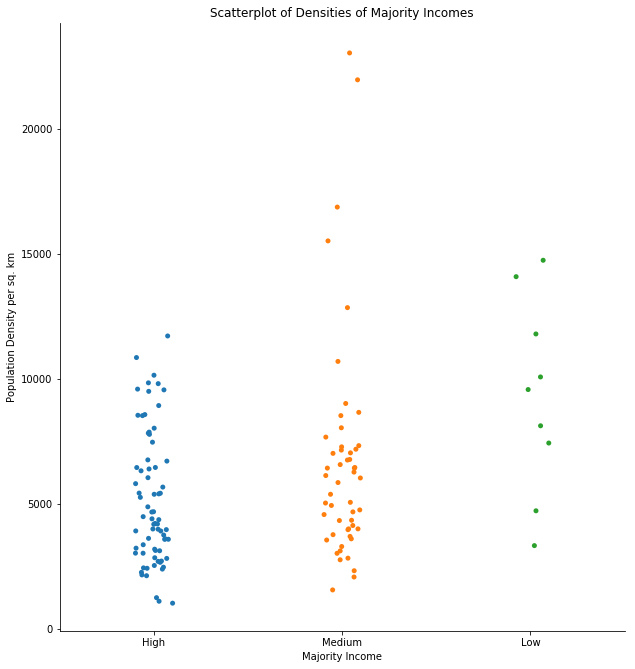

In [0]:
plot = sns.catplot(x="Majority Income",y="Population Density per sq. km",data=toronto_final_data,)
plot.ax.set_title("Scatterplot of Densities of Majority Incomes")
plot.savefig(base_dir+'population_income_scatter.png')
plot.fig.set_size_inches(10,10)

We can observe that the Low income groups belong to the smaller denser neighborhoods and the most dense areas contain a majority of medium income groups. Although most neighborhood areas contain High income groups, these areas are less dense and thus reduces the chances of more people coming to a new restaurant. We will need to observe trends of these income groups to see whether they would be interested in trying out a new restaurant or not

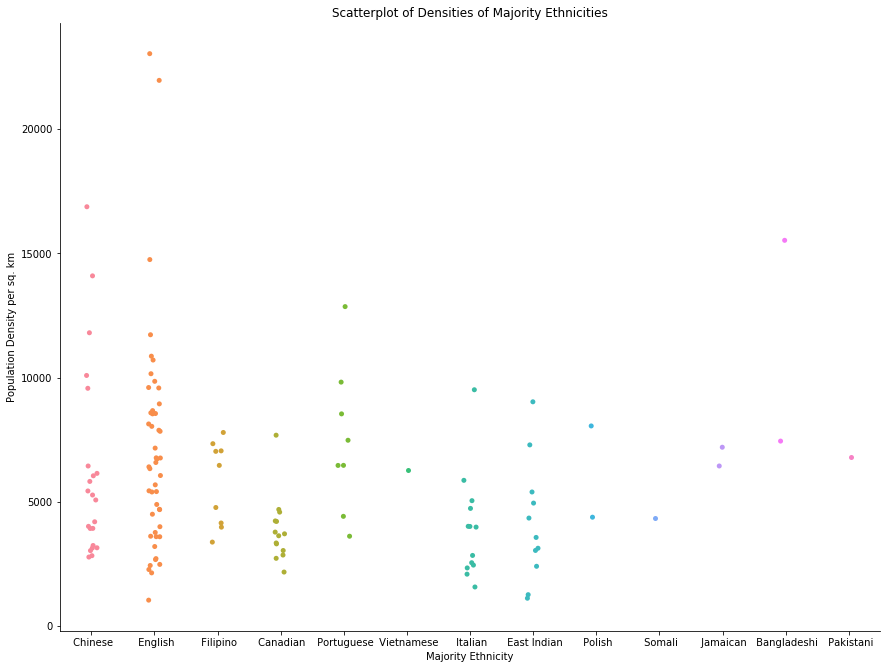

In [0]:
plot = sns.catplot(x="Majority Ethnicity",y="Population Density per sq. km",data=toronto_final_data)
plot.ax.set_title("Scatterplot of Densities of Majority Ethnicities")
plot.savefig(base_dir+'population_ethnicity_scatter.png')
plot.fig.set_size_inches(15,10)

Ethnically, the City of Toronto is pretty diverse and even though most people are either Chinese or English, people from other backgrounds like Bangladeshi are present in high density in a neighborhood. It is also interesting to note that people other than the English, have a lot of outlier groups with high densities. These groups could be the low to medium income groups present as observed from the previous cell.

In [0]:
common_venues = toronto_final_data[[col for col in toronto_final_data.columns if "Most" in col]]
common_venues = common_venues.apply(pd.Series.value_counts).dropna()
common_venues

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Bakery,1.0,3.0,3.0,2.0,1.0,3.0,1.0,1.0,2.0,1.0
Café,7.0,5.0,4.0,7.0,2.0,3.0,2.0,1.0,1.0,2.0
Fast Food Restaurant,6.0,2.0,4.0,8.0,7.0,9.0,2.0,2.0,13.0,12.0
Grocery Store,1.0,1.0,4.0,5.0,1.0,1.0,1.0,1.0,1.0,2.0
Italian Restaurant,1.0,5.0,3.0,3.0,2.0,1.0,1.0,1.0,2.0,1.0
Pizza Place,6.0,7.0,5.0,4.0,7.0,1.0,1.0,4.0,1.0,1.0
Sandwich Place,3.0,2.0,5.0,3.0,6.0,4.0,2.0,1.0,5.0,2.0
Zoo Exhibit,1.0,5.0,9.0,9.0,9.0,4.0,2.0,2.0,5.0,3.0


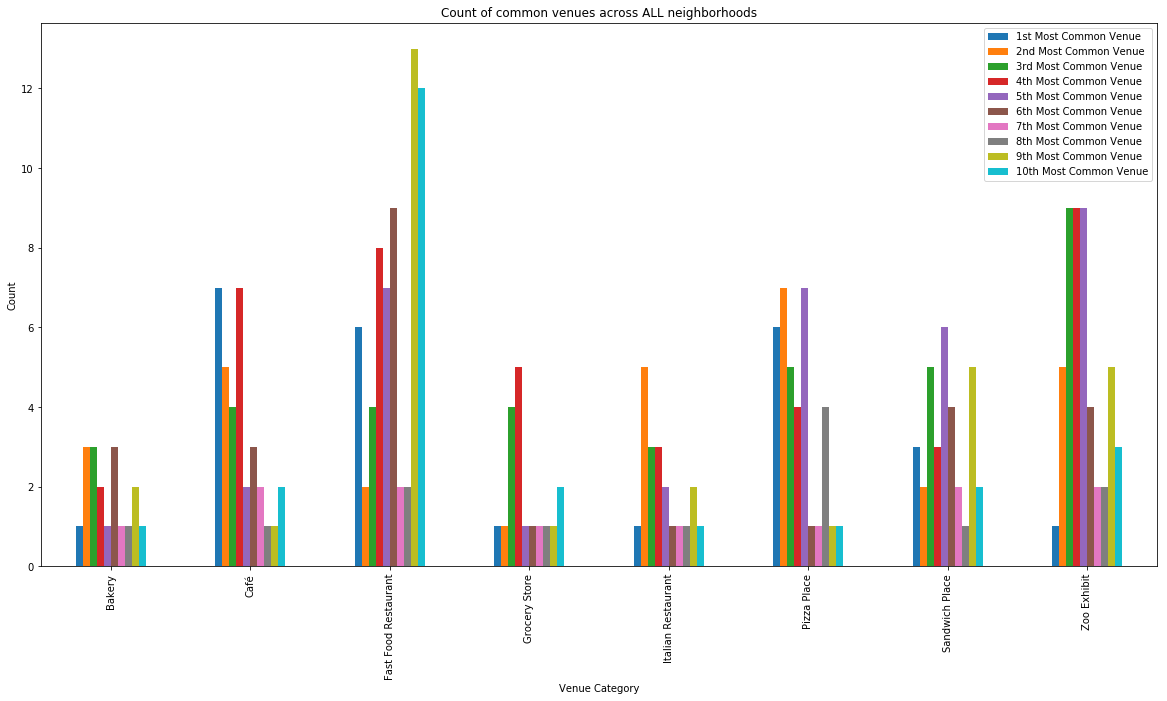

In [0]:
fig,ax = plt.subplots()
common_venues.plot(kind='bar',ax=ax)
ax.set_title("Count of common venues across ALL neighborhoods")
ax.set_ylabel('Count')
ax.set_xlabel('Venue Category')
fig.set_size_inches(20,10)
fig.savefig(base_dir+'common_venues_bar.png')

Here we view the venue categories which were present in EVERY single neighborhood in the top 10 most common venues. From a food business perspective, we can see that generally speaking, the best options would be Fast Food Restaurants, Pizza Places, Sandwich Places, Cafes and Italian restaurants in that order. The safest option amongst these would be a Fast Food restaurant though, as it has a high count for 6 out of the 10 ranks.

### Modeling

#### Segmenting Similar Neighborhoods

Now that we have sufficient information about each neighborhood. Let's group them together based on their similarities so we can suggest our client similar nieghborhoods for a chosen neighborhood

First, let's only group neighborhoods together based on the frequencies of venues of different categories.

In [0]:
kclusters = 5
cluster_input_A = cluster_input.drop('Neighborhood',axis=1)
kmeans = KMeans(n_clusters=kclusters, random_state=0,n_jobs=-1).fit(cluster_input_A.values)

In [0]:
labels_A = kmeans.labels_
labels_A[0:5]

array([1, 1, 1, 1, 1], dtype=int32)

In [0]:
toronto_final_data['Labels_A'] = labels_A

Now, let's use the addtional features we have obtained like density, income groups and ethnicity groups.

In [0]:
cluster_input.shape

(134, 269)

In [0]:
cluster_input_B = pd.merge(cluster_input,toronto_final_data,on='Neighborhood',copy=True)
cluster_input_B.shape

(134, 286)

In [0]:
cluster_input_B.columns[-20:]

Index(['Yoga Studio', 'Zoo', 'Zoo Exhibit', 'Geojson Key', 'Longitude',
       'Latitude', 'Population Density per sq. km', 'Majority Income',
       'Majority Ethnicity', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue', 'Labels_A'],
      dtype='object')

In [0]:
cluster_input_B['Population Density per sq. km'] = cluster_input_B['Population Density per sq. km']/cluster_input_B['Population Density per sq. km'].max()
cluster_input_B['Population Density per sq. km'].describe()

count    134.000000
mean       0.260335
std        0.158526
min        0.045131
25%        0.155952
50%        0.219537
75%        0.324141
max        1.000000
Name: Population Density per sq. km, dtype: float64

In [0]:
drop_cols = [col for col in toronto_final_data.columns if (('Majority' not in col) and ('Population Density' not in col) )]

In [0]:
drop_cols

['Neighborhood',
 'Geojson Key',
 'Longitude',
 'Latitude',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue',
 '6th Most Common Venue',
 '7th Most Common Venue',
 '8th Most Common Venue',
 '9th Most Common Venue',
 '10th Most Common Venue',
 'Labels_A']

In [0]:
cluster_input_B = cluster_input_B.drop(drop_cols,1)

In [0]:
cluster_input_B.columns[-20:]

Index(['Trail', 'Train Station', 'Tram Station', 'Tree', 'Turkish Restaurant',
       'Vegetarian / Vegan Restaurant', 'Video Game Store', 'Video Store',
       'Vietnamese Restaurant', 'Warehouse Store', 'Wine Bar', 'Wine Shop',
       'Wings Joint', 'Women's Store', 'Yoga Studio', 'Zoo', 'Zoo Exhibit',
       'Population Density per sq. km', 'Majority Income',
       'Majority Ethnicity'],
      dtype='object')

In [0]:
cluster_input_B = pd.get_dummies(cluster_input_B)

In [0]:
cluster_input_B.dtypes

African Restaurant                 float64
American Restaurant                float64
Amphitheater                       float64
Animal Shelter                     float64
Antique Shop                       float64
Argentinian Restaurant             float64
Art Gallery                        float64
Arts & Crafts Store                float64
Asian Restaurant                   float64
Athletics & Sports                 float64
Auto Dealership                    float64
Automotive Shop                    float64
BBQ Joint                          float64
Bagel Shop                         float64
Bakery                             float64
Bank                               float64
Bar                                float64
Baseball Field                     float64
Basketball Court                   float64
Beach                              float64
Beer Bar                           float64
Beer Store                         float64
Big Box Store                      float64
Bike Shop  

In [0]:
kmeans = KMeans(n_clusters=kclusters, random_state=0,n_jobs=-1).fit(cluster_input_B.values)

In [0]:
labels_B = kmeans.labels_
labels_B[0:5]

array([4, 0, 2, 2, 0], dtype=int32)

In [0]:
toronto_final_data['Labels_B'] = labels_B

In [0]:
toronto_final_data.head()

,Neighborhood,Geojson Key,Longitude,Latitude,Population Density per sq. km,Majority Income,Majority Ethnicity,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels_A,Labels_B
0,Agincourt North,Agincourt North (129),-79.266712,43.805441,3929,High,Chinese,Chinese Restaurant,Convenience Store,Japanese Restaurant,Pizza Place,Pharmacy,Park,Discount Store,Clothing Store,Sandwich Place,Fast Food Restaurant,1,4
1,Agincourt South-Malvern West,Agincourt South-Malvern West (128),-79.265612,43.788658,3034,Medium,Chinese,Chinese Restaurant,Pool Hall,Restaurant,Mediterranean Restaurant,Motorcycle Shop,Malay Restaurant,Shopping Mall,Cantonese Restaurant,Seafood Restaurant,Bank,1,0
2,Alderwood,Alderwood (20),-79.541611,43.604937,2435,High,English,Pizza Place,Convenience Store,Dance Studio,Pharmacy,Coffee Shop,Zoo Exhibit,Fish & Chips Shop,Event Space,Falafel Restaurant,Farmers Market,1,2
3,Annex,Annex (95),-79.404001,43.671585,10863,High,English,Park,Sandwich Place,Pizza Place,Pub,Coffee Shop,Café,Liquor Store,Pet Store,Cosmetics Shop,Donut Shop,1,2
4,Banbury-Don Mills,Banbury-Don Mills (42),-79.349718,43.737657,2775,Medium,Chinese,Clothing Store,Coffee Shop,Pharmacy,Movie Theater,Liquor Store,Cantonese Restaurant,Chocolate Shop,Gourmet Shop,Shoe Store,Italian Restaurant,1,0


In [0]:
toronto_final_data.to_csv(base_dir+'final_clustered_data.csv')

We now have two labels corresponding to different feature sets and have clustered all of the neighborhoods

In [0]:
clustered_data = pd.read_csv('./final_clustered_data.csv')
clustered_data.head()

,Neighborhood,Geojson Key,Longitude,Latitude,Population Density per sq. km,Majority Income,Majority Ethnicity,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels_A,Labels_B
0,Agincourt North,Agincourt North (129),-79.266712,43.805441,3929,High,Chinese,Chinese Restaurant,Convenience Store,Japanese Restaurant,Pizza Place,Pharmacy,Park,Discount Store,Clothing Store,Sandwich Place,Fast Food Restaurant,1,4
1,Agincourt South-Malvern West,Agincourt South-Malvern West (128),-79.265612,43.788658,3034,Medium,Chinese,Chinese Restaurant,Pool Hall,Restaurant,Mediterranean Restaurant,Motorcycle Shop,Malay Restaurant,Shopping Mall,Cantonese Restaurant,Seafood Restaurant,Bank,1,0
2,Alderwood,Alderwood (20),-79.541611,43.604937,2435,High,English,Pizza Place,Convenience Store,Dance Studio,Pharmacy,Coffee Shop,Zoo Exhibit,Fish & Chips Shop,Event Space,Falafel Restaurant,Farmers Market,1,2
3,Annex,Annex (95),-79.404001,43.671585,10863,High,English,Park,Sandwich Place,Pizza Place,Pub,Coffee Shop,Café,Liquor Store,Pet Store,Cosmetics Shop,Donut Shop,1,2
4,Banbury-Don Mills,Banbury-Don Mills (42),-79.349718,43.737657,2775,Medium,Chinese,Clothing Store,Coffee Shop,Pharmacy,Movie Theater,Liquor Store,Cantonese Restaurant,Chocolate Shop,Gourmet Shop,Shoe Store,Italian Restaurant,1,0


### Evaluation

Let's see what labels each set of features returns and compare them

In [0]:
clustered_data['Labels_A'].value_counts().to_frame()

,Labels_A
1,100
4,18
0,10
2,5
3,1


We can see that clustering neighborhoods together based on the frequency of  venues does not segment Toronto well. Almost every neighborhood has been assigned the same label i.e. Label 1. This is probably due to the sparsity of the input data. The input to this model was a matrix containing a lot zeroes and consequently the distances between these zero values between two nieghborhoods will also be zero, grouping them together in the same cluster. For this input data. 5 clusters is an overkill and there are essentially two clusters. Either your'e labelled 1, or not 1.

In [0]:
clustered_data['Labels_B'].value_counts().to_frame()

,Labels_B
0,45
2,37
4,36
1,9
3,7


After adding more inputs such as population density, income and ethniciy group, we give our algorithm more information to work with and we can see now that it has performed better in terms of segmenting. We can observe that Labels 1 and 3 have relatively much lower counts and this suggests that maybe we are defining more clusters than required to segment the data. Let's observe individual clusters and see if we can reduce the clusters to 3 clusters.

In [0]:
c1 = clustered_data.loc[clustered_data['Labels_B'] == 0, clustered_data.columns[[1] + list(range(0, clustered_data.shape[1]))]]
c2 = clustered_data.loc[clustered_data['Labels_B'] == 1, clustered_data.columns[[1] + list(range(0, clustered_data.shape[1]))]]
c3 = clustered_data.loc[clustered_data['Labels_B'] == 2, clustered_data.columns[[1] + list(range(0, clustered_data.shape[1]))]]
c4 = clustered_data.loc[clustered_data['Labels_B'] == 3, clustered_data.columns[[1] + list(range(0, clustered_data.shape[1]))]]
c5 = clustered_data.loc[clustered_data['Labels_B'] == 4, clustered_data.columns[[1] + list(range(0, clustered_data.shape[1]))]]

In [0]:
drop_cols = ['Neighborhood', 'Geojson Key', 'Longitude', 'Latitude', 'Population Density per sq. km', 'Labels_A', 'Labels_B']

Let's analyze individual clusters and see if we can give them a more meaningful label. Time to get our judgmental hats on!

In [0]:
c1.drop(drop_cols,1).describe()

,Majority Income,Majority Ethnicity,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,45,45,45,45,45,45,45,45,45,45,45,45
unique,1,12,28,33,32,34,32,31,29,28,27,25
top,Medium,Chinese,Coffee Shop,Pizza Place,Pharmacy,Zoo Exhibit,Zoo Exhibit,Ethiopian Restaurant,Event Space,Falafel Restaurant,Falafel Restaurant,Fast Food Restaurant
freq,45,8,9,4,4,3,5,5,5,5,5,5


It seems like this group of neighborhood enjoys going out for food. Majority of the neighborhood fall in this category, which is a good thing since we want to look for neighborhoods where people are interested in going out to have food. The income group is also medium which is fair since our client can set reasonable prices and people would still consider visiting restaurants frequently. Another good thing about this group is that it is well spread over Toronto which makes these neighborhoods good candidates for opening up a food chain. Let's call this group 'MEDIUM INCOME FOODIES'

In [0]:
visualize_clusters(c1,latitude,longitude,cluster_label='Labels_B')

In [0]:
clustered_named_labels = clustered_data.copy()
clustered_named_labels['Labels_B'] = clustered_data['Labels_B'].replace(to_replace=0,value='MEDIUM INCOME FOODIES')
clustered_named_labels.head(3)

,Neighborhood,Geojson Key,Longitude,Latitude,Population Density per sq. km,Majority Income,Majority Ethnicity,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels_A,Labels_B
0,Agincourt North,Agincourt North (129),-79.266712,43.805441,3929,High,Chinese,Chinese Restaurant,Convenience Store,Japanese Restaurant,Pizza Place,Pharmacy,Park,Discount Store,Clothing Store,Sandwich Place,Fast Food Restaurant,1,4
1,Agincourt South-Malvern West,Agincourt South-Malvern West (128),-79.265612,43.788658,3034,Medium,Chinese,Chinese Restaurant,Pool Hall,Restaurant,Mediterranean Restaurant,Motorcycle Shop,Malay Restaurant,Shopping Mall,Cantonese Restaurant,Seafood Restaurant,Bank,1,MEDIUM INCOME FOODIES
2,Alderwood,Alderwood (20),-79.541611,43.604937,2435,High,English,Pizza Place,Convenience Store,Dance Studio,Pharmacy,Coffee Shop,Zoo Exhibit,Fish & Chips Shop,Event Space,Falafel Restaurant,Farmers Market,1,2


In [0]:
c2.drop(drop_cols,1).describe()

,Majority Income,Majority Ethnicity,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,9,9,9,9,9,9,9,9,9,9,9,9
unique,1,5,7,9,9,9,9,9,8,8,8,8
top,Low,English,Coffee Shop,Home Service,Electronics Store,Fish & Chips Shop,Gastropub,Restaurant,Flea Market,Fish Market,Fast Food Restaurant,Field
freq,9,3,2,1,1,1,1,1,2,2,2,2


In [0]:
visualize_clusters(c2,latitude,longitude,cluster_label='Labels_B')

The most noticable observation about this group is that most of these neighborhoods are along the coastal line and consequently have Fish Market and Fish and Chips amongst their top 10 most common venues. These are low income groups where people probably cannot afford to go out to eat more frequently and therefore restaurants are not that famous in these neighborhoods. Let's call these groups 'LOW INCOME NON-FOODIES'

In [0]:
clustered_named_labels['Labels_B'] = clustered_named_labels['Labels_B'].replace(to_replace=1,value='LOW INCOME NON-FOODIES')
clustered_named_labels['Labels_B'].value_counts()

MEDIUM INCOME FOODIES     45
2                         37
4                         36
LOW INCOME NON-FOODIES     9
3                          7
Name: Labels_B, dtype: int64

In [0]:
c3.drop(drop_cols,1).describe()

,Majority Income,Majority Ethnicity,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,37,37,37,37,37,37,37,37,37,37,37,37
unique,1,1,21,23,32,28,26,25,29,26,26,26
top,High,English,Park,Coffee Shop,Park,Café,Sandwich Place,Event Space,Event Space,Falafel Restaurant,Farmers Market,Egyptian Restaurant
freq,37,37,6,5,2,4,4,4,5,5,5,3


In [0]:
visualize_clusters(c3,latitude,longitude,cluster_label='Labels_B')

This group of neighborhood, seems to have a fast-paced workaholic environment where people most frequently visit Cafes and Coffee Shops. Only two types of restaurants occur in the top 10 most common venues. These groups do have Event spaces as popular venues which indicates these are common places for events or festivals. These are the second largest group ammongst the 5 groups of neighborhood and are located closer to the airport and coastal lines. These neighborhoods possibly have the most company offices as well. Let's call this group 'HIGH INCOME NON-FOODIES'

In [0]:
clustered_named_labels['Labels_B'] = clustered_named_labels['Labels_B'].replace(to_replace=2,value='HIGH INCOME NON-FOODIES')
clustered_named_labels['Labels_B'].value_counts()

MEDIUM INCOME FOODIES      45
HIGH INCOME NON-FOODIES    37
4                          36
LOW INCOME NON-FOODIES      9
3                           7
Name: Labels_B, dtype: int64

In [0]:
c4.drop(drop_cols,1).describe()

,Majority Income,Majority Ethnicity,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,7,7,7,7,7,7,7,7,7,7,7,7
unique,1,1,5,6,7,7,7,7,6,6,6,7
top,Medium,Italian,Park,Zoo Exhibit,Electronics Store,Zoo Exhibit,Event Space,Department Store,Event Space,Falafel Restaurant,Farmers Market,Flea Market
freq,7,7,3,2,1,1,1,1,2,2,2,1


In [0]:
visualize_clusters(c4,latitude,longitude,cluster_label='Labels_B')

Looks like people in this group are not that fond of food in general. They will prefer to just chill at some park or take their kids to Zoos. Let's call them 'MEDIUM INCOME NON-FOODIES'

In [0]:
clustered_named_labels['Labels_B'] = clustered_named_labels['Labels_B'].replace(to_replace=3,value='MEDIUM INCOME NON-FOODIES')
clustered_named_labels['Labels_B'].value_counts()

MEDIUM INCOME FOODIES        45
HIGH INCOME NON-FOODIES      37
4                            36
LOW INCOME NON-FOODIES        9
MEDIUM INCOME NON-FOODIES     7
Name: Labels_B, dtype: int64

In [0]:
c5.drop(drop_cols,1).describe()

,Majority Income,Majority Ethnicity,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
count,36,36,36,36,36,36,36,36,36,36,36,36
unique,1,7,26,21,27,25,22,24,21,22,20,21
top,High,Chinese,Park,Park,Zoo Exhibit,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field
freq,36,11,5,8,5,4,5,5,6,6,6,5


In [0]:
visualize_clusters(c5,latitude,longitude,cluster_label='Labels_B')

We have another very good candidate group for opening up a food chain. These are High income groups which frequently go out to eat. Moreover, these groups have parks and Zoo exhibits as the most common venues which indicates that majority of the households are families with kids. These neighborhoods are the 3rd most largest group and although not very well spread over Toronto, would still make a good Candidate. Let's call this group 'HIGH INCOME FOODIES'

In [0]:
clustered_named_labels['Labels_B'] = clustered_named_labels['Labels_B'].replace(to_replace=4,value='HIGH INCOME FOODIES')
clustered_named_labels['Labels_B'].value_counts()

MEDIUM INCOME FOODIES        45
HIGH INCOME NON-FOODIES      37
HIGH INCOME FOODIES          36
LOW INCOME NON-FOODIES        9
MEDIUM INCOME NON-FOODIES     7
Name: Labels_B, dtype: int64

In [0]:
clustered_named_labels.to_csv('./clustered_named_labels.csv',index=False)

## Results

Although the requirement was to figure out a candidate neighborhood first and then find similar neighborhoods, it seems like a much better approach to first segment the neighbors and assign them meaningful labels. This allows our client to select a target audience and then further analyze that segment to find the best options for setting up their restaurant

In [0]:
I will be using the MEDIUM INCOME FOODIES group as it is the largest group but the analysis can easily be replicated for other groups, HIGH INCOME FOODIES in particular, since that is the other best option out of the five.

In [0]:
target_group = clustered_named_labels[clustered_named_labels['Labels_B'] == 'MEDIUM INCOME FOODIES']
target_group

,Neighborhood,Geojson Key,Longitude,Latitude,Population Density per sq. km,Majority Income,Majority Ethnicity,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels_A,Labels_B
1,Agincourt South-Malvern West,Agincourt South-Malvern West (128),-79.265612,43.788658,3034,Medium,Chinese,Chinese Restaurant,Pool Hall,Restaurant,Mediterranean Restaurant,Motorcycle Shop,Malay Restaurant,Shopping Mall,Cantonese Restaurant,Seafood Restaurant,Bank,1,MEDIUM INCOME FOODIES
4,Banbury-Don Mills,Banbury-Don Mills (42),-79.349718,43.737657,2775,Medium,Chinese,Clothing Store,Coffee Shop,Pharmacy,Movie Theater,Liquor Store,Cantonese Restaurant,Chocolate Shop,Gourmet Shop,Shoe Store,Italian Restaurant,1,MEDIUM INCOME FOODIES
10,Beechborough-Greenbrook,Beechborough-Greenbrook (112),-79.479473,43.693216,3614,Medium,Portuguese,Convenience Store,Fast Food Restaurant,Sandwich Place,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Field,Egyptian Restaurant,0,MEDIUM INCOME FOODIES
11,Bendale,Bendale (127),-79.257400,43.760366,4011,Medium,Chinese,Park,Tennis Court,History Museum,Greek Restaurant,Zoo Exhibit,Farmers Market,Elementary School,Ethiopian Restaurant,Event Space,Falafel Restaurant,4,MEDIUM INCOME FOODIES
13,Black Creek,Black Creek (24),-79.521979,43.764890,6282,Medium,Vietnamese,Athletics & Sports,Shopping Mall,Pharmacy,Snack Place,Zoo Exhibit,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,1,MEDIUM INCOME FOODIES
17,Broadview North,Broadview North (57),-79.355630,43.688825,6764,Medium,English,Discount Store,Pizza Place,Theater,Bakery,Bus Stop,Grocery Store,Flea Market,Flower Shop,Fish Market,Fish & Chips Shop,1,MEDIUM INCOME FOODIES
22,Church-Yonge Corridor,Church-Yonge Corridor (75),-79.379017,43.659649,23044,Medium,English,Coffee Shop,Ramen Restaurant,Movie Theater,Falafel Restaurant,Clothing Store,Japanese Restaurant,Diner,Burger Joint,Café,Gastropub,1,MEDIUM INCOME FOODIES
24,Clanton Park,Clanton Park (33),-79.446303,43.741978,3979,Medium,Filipino,Park,IT Services,Home Service,Health & Beauty Service,Zoo Exhibit,Fast Food Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,4,MEDIUM INCOME FOODIES
29,Don Valley Village,Don Valley Village (47),-79.353644,43.783294,6441,Medium,Chinese,Fast Food Restaurant,Bakery,Grocery Store,Beer Store,Caribbean Restaurant,Skating Rink,Park,Pizza Place,Fried Chicken Joint,Sandwich Place,0,MEDIUM INCOME FOODIES
30,Dorset Park,Dorset Park (126),-79.278908,43.759274,4146,Medium,Filipino,Pet Store,Furniture / Home Store,Indian Restaurant,Vietnamese Restaurant,Fast Food Restaurant,Electronics Store,Automotive Shop,Field,Ethiopian Restaurant,Event Space,1,MEDIUM INCOME FOODIES


Let's get a better insight on this group now. We see that these neighborhoods are not dominated by people of English origins. It mainly consists of people from Asia and thus the cuisines of the popular restaurants vary a lot. The safer option would be to go for cuisines which are popular regardless of ethnicity for instance Pizza Places, Burger Joints and other Fast Food Restaurants. But let's make a claim which is supported by data

In [0]:
all_venues = []
common_venues = clustered_named_labels[[col for col in clustered_named_labels.columns if "Most" in col]].copy()
common_venues.apply(lambda col_values: all_venues.extend(col_values.tolist()),axis=1)
all_venues = pd.Series(all_venues)
all_venues.value_counts().head(10)

Fast Food Restaurant    65
Falafel Restaurant      60
Event Space             59
Farmers Market          56
Coffee Shop             52
Ethiopian Restaurant    50
Park                    50
Zoo Exhibit             49
Field                   40
Pizza Place             37
dtype: int64

We can see that our initial observation was somewhat correct. A Fast food restaurant would be the best option to open up in these neighborhoods. It is interesting to note that people in these neighborhoods prefer Falafel and Ethiopian Restaurants to Pizza Places which I was not expecting due to the ethnic diversity

In [0]:
Although Fast Food Restaurants are the most popular venues, we can't suggest our client to go ahead and start a Fast Food Restaurant. We will need to see the existing competition in the market and whether the market is saturated or not. Because if there are already a lot of **good** options for people, they most probably won't be frequently visiting a new place. Let's see the top Fast Food Restaurants in these neighborhoods.

In [0]:
neighborhoods = target_group['Neighborhood'].tolist()
len(neighborhoods)

45

In [0]:
market_competition = None
keys = restaurants_grouped.groups.keys()
for area in neighborhoods:
    if area in keys:
        df = restaurants_grouped.get_group(area)
        if market_competition is None:
            market_competition = df
        else:
            market_competition = pd.concat([market_competition,df],ignore_index=True)
market_competition.shape

(431, 11)

So we have 431 restaurants in these areas. Let's filter out the fast food restaurants only and sort them based on their ratings. This will narrow down our potential competitions list

In [0]:
market_competition.head()

,business_id,Name,Categories,Stars,Useful,Review_count,Address,Postal_code,Neighborhood,Longitude,Latitude
0,K2CdjES-IZDDEgetOnf0Vw,One2 Snacks,"Asian Fusion, Fast Food, Malaysian, Restaurant...",4.38,1.15,172,"8 Glen Watford Drive, Unit 26",M1S 2C1,Agincourt South-Malvern West,-79.276623,43.787190
1,cWPTOM_o5toaXpq0gNxD7Q,BlackGold Cafe,"Cafes, Restaurants, Coffee & Tea, Sandwiches, ...",4.13,1.94,156,2101 Brimley Road,M1S 2B4,Agincourt South-Malvern West,-79.268636,43.788839
2,mUUTJY9_BqmAYxypHiqWrw,Francesca Italian Bakery & Delicatessen,"Food, Restaurants, Desserts, Bakeries, Italian...",4.00,1.23,125,2 Invergordon Avenue,M1S 2Y8,Agincourt South-Malvern West,-79.256700,43.787819
3,x3JHj5h33ouzw_Ynj-utJg,Asian Legend,"Chinese, Restaurants",3.70,0.93,104,4452 Sheppard Avenue E,M1S 2V7,Agincourt South-Malvern West,-79.267270,43.788375
4,2VtTzskzFcwVnXgGYsY1lQ,The Captain's Boil,"Seafood, Asian Fusion, Cajun/Creole, Restaurants",3.57,0.77,53,4505 Sheppard Avenue E,M1S,Agincourt South-Malvern West,-79.264716,43.787913


In [0]:
market_competition = market_competition[market_competition['Categories'].str.contains('Fast Food')]
market_competition.shape

(18, 11)

We have narrowed down our competitions to 18 Fast Food Restaurants

In [0]:
market_competition = market_competition.sort_values('Stars',ascending=False)
market_competition.head(10)

,business_id,Name,Categories,Stars,Useful,Review_count,Address,Postal_code,Neighborhood,Longitude,Latitude
41,pSMK_FtULKiU-iuh7SMKwg,Blaze Fast-Fire'd Pizza,"Gluten-Free, Restaurants, Salad, Pizza, Fast Food",4.50,0.94,434,"10 Dundas Street East, #124",M5B 2G9,Church-Yonge Corridor,-79.380043,43.656531
0,K2CdjES-IZDDEgetOnf0Vw,One2 Snacks,"Asian Fusion, Fast Food, Malaysian, Restaurant...",4.38,1.15,172,"8 Glen Watford Drive, Unit 26",M1S 2C1,Agincourt South-Malvern West,-79.276623,43.787190
294,wL5yGvlL1zXZ4EPJ8d0hIA,Rolltation,"Food, Fast Food, Poke, Sushi Bars, Restaurants...",4.15,0.88,81,2291 Yonge Street,M4P 2C6,Mount Pleasant West,-79.398122,43.707550
54,PjtX-5vSTBVyWfMREX8bRA,Capitano Burgers & Gelato,"Burgers, Ice Cream & Frozen Yogurt, Fast Food,...",4.12,2.59,78,645 Yonge Street,M4Y 1Z9,Church-Yonge Corridor,-79.385682,43.667917
61,yiKd42V_SoI_08DL62twDQ,Doner Kebab House,"Donairs, Middle Eastern, Turkish, Fast Food, F...",4.04,0.68,111,385 Yonge Street,M5B 1S1,Church-Yonge Corridor,-79.381797,43.658745
223,ixGb4NLfgD90wZHlw94rLw,Pizza La Rosa,"Fast Food, Italian, Sandwiches, Salad, Restaur...",4.00,3.90,67,"2555 Victoria Park Avenue, Unit 19",M1T 1A3,Henry Farm,-79.321859,43.772573
344,hMEVbme_dTIwpQ1iphPOLA,Asteria Souvlaki Place,"Mediterranean, Fast Food, Greek, Restaurants",3.76,0.90,49,292 Danforth Avenue,M4K 1N6,Playter Estates-Danforth,-79.354252,43.677376
97,Qqm3yVcqTbC1IOKu0TG2nQ,Dal Moro's Fresh Pasta To Go,"Italian, Restaurants, Fast Food",3.67,1.34,121,605 Yonge Street,M4Y 1Z5,Church-Yonge Corridor,-79.385165,43.666786
203,F9tePBgROEAcd8xZqTZUfg,Jollibee,"Fast Food, Filipino, Restaurants, Chicken Wings",3.65,2.91,174,15 William Kitchen Road,M1P 5B7,Dorset Park,-79.281207,43.773139
13,tCTMmTfqD1PD8_VDOgoB0w,Five Guys,"Burgers, Sandwiches, Fast Food, Hot Dogs, Rest...",3.61,0.74,53,865 York Mills Road,M3B 1Y6,Banbury-Don Mills,-79.349493,43.754171


Let's see where these restaurants are located.

In [0]:
visualize_points(market_competition,latitude,longitude,label_B='Name')

In [0]:
market_competition['Neighborhood'].value_counts()

Church-Yonge Corridor           7
Banbury-Don Mills               3
Mount Pleasant West             2
Little Portugal                 2
Agincourt South-Malvern West    1
Playter Estates-Danforth        1
Dorset Park                     1
Henry Farm                      1
Name: Neighborhood, dtype: int64

Church-Yonge Corridor has majority of the potential competition including 3 out of the top 5 potential competitors. So Opening a restaurant here would probably be a bad idea since it already has a high competition and a lot of restaurants

In [0]:
market_competition.tail()

,business_id,Name,Categories,Stars,Useful,Review_count,Address,Postal_code,Neighborhood,Longitude,Latitude
134,JrB6On8q8f1_ICQSCLg47w,Five Guys,"Restaurants, Fast Food, American (Traditional)...",3.35,0.87,140,329 Yonge Street,M5B 1A1,Church-Yonge Corridor,-79.381005,43.657031
18,Mksyt1TZQ-7vzCZjeuzfAg,CASA manila Restaurant,"Fast Food, Restaurants, Chinese, Filipino",3.30,1.42,254,"879 York Mills Road, Unit 1",M3B 1Y5,Banbury-Don Mills,-79.348888,43.754956
321,DYGCzsHi7pT4AAe8kh5Dug,Chipotle Mexican Grill,"Fast Food, Mexican, Restaurants",3.26,0.67,84,"2323 Yonge St, Unit 100",M4P 2C9,Mount Pleasant West,-79.398406,43.708198
265,NDuUMJfrWk52RA-H-OtrpA,Bolt Fresh Bar,"Juice Bars & Smoothies, Food, Restaurants, Fas...",3.12,2.47,57,1170 Queen Street W,M6J 1J5,Little Portugal,-79.425429,43.642889
188,A71qH8j6c1P_iPvY-q9cVg,Popeyes Louisiana Kitchen,"Fast Food, Chicken Wings, Restaurants",2.36,1.64,50,273 Yonge Street,M5B 1N8,Church-Yonge Corridor,-79.380340,43.655414


Upon looking the top 5 least rated restaurants we see that Church-Yorge Corridor also contains 2 out of the 5 least rated restaurants which makes sense since people have already developed high standards due to the top rated restaurants in this location

One restaurant that caught my eye was the CASA manila Restaurant, its a relatively low rated chinese/filipino restaurant located in a chinese majority area. There are only 3 Fast Food restaurants in this neighborhood and this seems like a good option to start a Chinese Fast Food Restaurant. Let's look more into Banbury-Don Mills

In [0]:
selected_area = 'Banbury-Don Mills'
target_group[target_group['Neighborhood'] == selected_area]

,Neighborhood,Geojson Key,Longitude,Latitude,Population Density per sq. km,Majority Income,Majority Ethnicity,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Labels_A,Labels_B
4,Banbury-Don Mills,Banbury-Don Mills (42),-79.349718,43.737657,2775,Medium,Chinese,Clothing Store,Coffee Shop,Pharmacy,Movie Theater,Liquor Store,Cantonese Restaurant,Chocolate Shop,Gourmet Shop,Shoe Store,Italian Restaurant,1,MEDIUM INCOME FOODIES


In [0]:
restaurants_grouped.get_group(selected_area).reset_index(drop=True)

,business_id,Name,Categories,Stars,Useful,Review_count,Address,Postal_code,Neighborhood,Longitude,Latitude
0,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,"Restaurants, Italian, Cafes",4.80,0.86,267,1262 Don Mills Road,M3B 2W7,Banbury-Don Mills,-79.346468,43.744703
1,yHCoJZh5nx0Onr5xgMaUHg,Galleria Supermarket,"Ethical Grocery, Restaurants, International Gr...",4.00,1.39,107,865 York Mills Road,M3B 1Y6,Banbury-Don Mills,-79.349421,43.753722
2,iQDPdxmXXvW-mgy9gsKXhQ,Starbucks Reserve,"Restaurants, Cafes, Coffee & Tea, Coffee Roast...",3.82,4.47,52,1070 Don Mills Road,M3C 0H4,Banbury-Don Mills,-79.344001,43.735071
3,ik9VvawL-BeAqlxTI1leew,Gonoe Sushi,"Sushi Bars, Japanese, Restaurants",3.70,0.66,108,1310 Don Mills Road,M3B 2W6,Banbury-Don Mills,-79.346301,43.745920
4,tCTMmTfqD1PD8_VDOgoB0w,Five Guys,"Burgers, Sandwiches, Fast Food, Hot Dogs, Rest...",3.61,0.74,53,865 York Mills Road,M3B 1Y6,Banbury-Don Mills,-79.349493,43.754171
5,cPXasVLtq_1gmuSg65TUfQ,Dragon Pearl Buffet,"Chinese, Restaurants, Buffets",3.50,2.07,305,"865 York Mills Road, Unit 2",M3B 1Y8,Banbury-Don Mills,-79.349892,43.755169
6,GZ12skjXwuMuH3LidRN-mA,Chipotle Mexican Grill,"Restaurants, Spanish, Fast Food, Mexican",3.49,0.51,58,1072 Don Mills Rd,M4P 2C9,Banbury-Don Mills,-79.343318,43.736359
7,wKmDYX_XuYCbIerCbYfWnQ,The Captain's Boil,"Asian Fusion, Seafood, Restaurants, Cajun/Creole",3.33,1.35,70,"865 York Mills Rd, Suite 10A",M3B 1Y6,Banbury-Don Mills,-79.349670,43.754866
8,OBG1j517k7aZRNC1HAL0TA,Fabbrica,"Italian, Breakfast & Brunch, Pizza, Restaurant...",3.33,0.96,187,49 Karl Fraser Road,M3C 0E5,Banbury-Don Mills,-79.344650,43.736620
9,Mksyt1TZQ-7vzCZjeuzfAg,CASA manila Restaurant,"Fast Food, Restaurants, Chinese, Filipino",3.30,1.42,254,"879 York Mills Road, Unit 1",M3B 1Y5,Banbury-Don Mills,-79.348888,43.754956


This neighborhood contains 24 restaurants, majority of them have asian cuisines. Contrary to our previous belief of opening up a "safe" option like burgers or pizzas, it now seems a better idea to be specific in our selection of cuisines and target a very specific audience. Most of these restaurants have a below average rating and it seems like the people in these neighborhood could use a really good Asian cuisine restaurant.

Before we make our final conclusions, let's see what people actually like about the top rated restaurants in this neighborhood

In [0]:
top_5 = restaurants_grouped.get_group(selected_area).reset_index(drop=True).sort_values('Stars',ascending=False).head(5)
top_5

,business_id,Name,Categories,Stars,Useful,Review_count,Address,Postal_code,Neighborhood,Longitude,Latitude
0,g6AFW-zY0wDvBl9U82g4zg,Baretto Caffe,"Restaurants, Italian, Cafes",4.80,0.86,267,1262 Don Mills Road,M3B 2W7,Banbury-Don Mills,-79.346468,43.744703
1,yHCoJZh5nx0Onr5xgMaUHg,Galleria Supermarket,"Ethical Grocery, Restaurants, International Gr...",4.00,1.39,107,865 York Mills Road,M3B 1Y6,Banbury-Don Mills,-79.349421,43.753722
2,iQDPdxmXXvW-mgy9gsKXhQ,Starbucks Reserve,"Restaurants, Cafes, Coffee & Tea, Coffee Roast...",3.82,4.47,52,1070 Don Mills Road,M3C 0H4,Banbury-Don Mills,-79.344001,43.735071
3,ik9VvawL-BeAqlxTI1leew,Gonoe Sushi,"Sushi Bars, Japanese, Restaurants",3.70,0.66,108,1310 Don Mills Road,M3B 2W6,Banbury-Don Mills,-79.346301,43.745920
4,tCTMmTfqD1PD8_VDOgoB0w,Five Guys,"Burgers, Sandwiches, Fast Food, Hot Dogs, Rest...",3.61,0.74,53,865 York Mills Road,M3B 1Y6,Banbury-Don Mills,-79.349493,43.754171


The only Asian cuisine restaurant in the top 5 is the Gonoe Sushi Restaurant. Let's see more about this restaurant.

In [0]:
customer_reviews = pd.read_csv('./Toronto_restaurants_reviews.csv')

In [0]:
competitor = 'ik9VvawL-BeAqlxTI1leew'
competitor_hours = restaurants_hours[restaurants_hours['business_id'] == competitor]
competitor_attributes = restaurant_attributes[restaurant_attributes['business_id'] == competitor]
competitor_reviews = customer_reviews[customer_reviews['business_id'] == competitor]

In [0]:
competitor_hours

,business_id,name,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
2242,ik9VvawL-BeAqlxTI1leew,Gonoe Sushi,11:30-22:30,11:30-22:30,11:30-22:30,11:30-22:30,11:30-23:0,11:30-23:0,12:0-22:0


Since our competitor is familiar with its customer base, we can simply replicate their timings or even extend them.

In [0]:
competitor_attributes = competitor_attributes.dropna(axis='columns')
competitor_attributes

,business_id,name,RestaurantsAttire,GoodForMeal,BikeParking,NoiseLevel,RestaurantsTableService,GoodForKids,OutdoorSeating,Ambience,RestaurantsPriceRange2,RestaurantsTakeOut,Alcohol,RestaurantsDelivery,RestaurantsGoodForGroups,WiFi,RestaurantsReservations,BusinessParking,HasTV,Caters
4260,ik9VvawL-BeAqlxTI1leew,Gonoe Sushi,u'casual',"{'dessert': False, 'latenight': False, 'lunch'...",True,u'average',True,True,False,"{'romantic': False, 'intimate': False, 'classy...",2,True,u'beer_and_wine',False,True,u'no',True,"{'garage': False, 'street': False, 'validated'...",False,True


Our client can replicate these attributes and even go above and beyond by incorporating missing attributes. For instance they can add Outdoor seating so people can enjoy food outdoors when the weather is nice. Our client can offer home delivery for those lazy foodies who'd prefer to eat at home. They can add WiFi (Who doesn't love free internet, right?) and TV. 

It is also interesting to note that the price range is of level 2 which is medium, not too expensive and not too cheap which aligns with our label of this neighborhood as a medium income group

In [0]:
competitor_attributes['GoodForMeal'].values.tolist()[0]

"{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}"

Our competitor has been rated Good for Lunches and Dinners. Our client can either compete on these two meals or offer more variety to attract customers. We can also carry out an analysis where we can compare top rated restaurants in the area and see what they offered

In [0]:
competitor_attributes['Ambience'].values.tolist()[0]

"{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}"

Our competitor has a "Casual" ambience, which seems reasonable but we can always add a more "classy" or "romantic" touch to it

In [0]:
competitor_attributes['BusinessParking'].values.tolist()[0]

"{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}"

They only have a parking lot parking. Our client can step up their game by adding valet parking

Additionally, the client's business team can go ahead and read all reviews to gain an idea of what their competitor is doing right and what they're doing wrong. For our analysis we will stick to binaries of Good Reviews (5 Stars) or a Bad Review (1 Star)

In [0]:
competitor_reviews.shape

(110, 9)

In [0]:
good_reviews = competitor_reviews[competitor_reviews['stars'] == 5.0]
good_reviews.shape

(30, 9)

So our competitor has 30 good reviews, let's read a few, specifically those which other user's found useful

In [0]:
good_reviews = good_reviews.sort_values(['useful','cool','date'],ascending=False)
good_reviews_list = good_reviews['text'].head().tolist()
good_reviews.head()

,stars,review_id,date,useful,text,user_id,funny,cool,business_id
143865,5.0,59cITG1EjUGfoNSn5NaXxA,2018-07-27 01:21:09,9,"First time trying this gem, and it was absolut...",utjGh0V0XweisHuHM6Wn3Q,2,11,ik9VvawL-BeAqlxTI1leew
165799,5.0,jR7Yq3XevEikp1Kj5u6ZCA,2016-04-18 13:50:11,6,"We, party of 4, came here for dinner. As I men...",p_fas65QL25jqfV2tSSnQQ,4,4,ik9VvawL-BeAqlxTI1leew
146482,5.0,9va_1j4JRgrcf4gONGkrwg,2015-04-02 21:17:20,3,"Thanks to Yelp, I found this little gem!\n\nOr...",XNbrAATnVNAg1eTjMjn-pA,0,0,ik9VvawL-BeAqlxTI1leew
150997,5.0,s6kc6DiWRHMOXYJsJBA4jA,2015-08-24 17:54:50,2,Fresh flounder. The whole fish is flown in fro...,z3UOaGaLWmcSzTED_EePfg,0,0,ik9VvawL-BeAqlxTI1leew
166156,5.0,YU9l-tnGaJgFJFTZuGlkNg,2015-04-13 14:18:29,2,A friend recommended me this place. It is prob...,MUTKPdivWB4OPpnv3STjGA,0,0,ik9VvawL-BeAqlxTI1leew


In [0]:
good_reviews_list[0]

"First time trying this gem, and it was absolutely worth it!\nThis place makes authentic sushi like you have never tried elsewhere!\n\nIn terms of the interiors, it is a centric with little booths with curtains hanging down, they are nice for a little private group, or there are a few tables scattered around. It may need some renovations or adding a little Mondrian touch to it.\n\nHowever, this is not too important compared to the quality of food in this place.\nWe ordered Edamame which was pretty good and shrimp tempura which was OK\nAs for sushi, we ordered the Green Dragon, lobster salad Maki roll and the short beef ribs roll\nThe presentation was beautiful, and we received way more rolls than we had anticipated based on the menu.\nEach role tasted better than the one before, it's hard very thin layer of rice but so much feelings inside, that we were struggling to finish the portion.\n\nThere is no all you can eat option, and it is a bit pricey to order from the alacart menu, but it

Seems like this particular customer really admired the interior of the restaurant but more importantly loved the food. They do think that it is a bit pricey but they still would like to have an all you can eat option offered.

In [0]:
bad_reviews = competitor_reviews[competitor_reviews['stars'] == 1.0]
bad_reviews.shape

(5, 9)

Our competitor has only 5 bad reviews which is pretty neat but let's see what people disliked about them

In [0]:
bad_reviews = bad_reviews.sort_values(['useful','cool','date'],ascending=False)
bad_reviews_list = bad_reviews['text'].head().tolist()
bad_reviews.head()

,stars,review_id,date,useful,text,user_id,funny,cool,business_id
162203,1.0,z4g-y6OUa9N_TnLFr648yw,2017-02-05 07:09:06,2,This is the worst restaurant I've ever experie...,d8Nz9m-8pYosZKPjd9yNBA,0,0,ik9VvawL-BeAqlxTI1leew
165877,1.0,PC8tAQW2neRnTW1axuPWcA,2018-09-01 22:16:34,1,Very bad service! The waitress are slow and ru...,1aswe_vRwSOzHqs18LGarw,0,0,ik9VvawL-BeAqlxTI1leew
163166,1.0,BPwtioO7tyD2cVX0Y6dcRQ,2017-09-29 00:35:45,0,I used to love this place when I moved to Toro...,PQXLtb5C8eT7KUoWpIi8aQ,0,0,ik9VvawL-BeAqlxTI1leew
141888,1.0,rjW5PzfIm1W4L46udOTCog,2015-07-28 17:45:22,0,Ordered the Agedashi Tofu and Salmon Sushi Piz...,f0JSzTCEhWufk0AkbH6BSg,1,0,ik9VvawL-BeAqlxTI1leew
170785,1.0,xlGvNOktvPi04CJZLLbq-A,2015-06-07 00:26:42,0,The food were so common and didnt even taste g...,ghpshF_nJsqk5ETtUCF94w,0,0,ik9VvawL-BeAqlxTI1leew


In [0]:
bad_reviews_list[0]

"This is the worst restaurant I've ever experienced. They gave me Amaebi that was microwaved to defrost. I could tell from the hard clump texture that I felt while biting into the sashimi and how warm the shrimp was. Which is regularly a softer texture and a delicate shellfish to serve. I had mild food poisoning from this. We also ordered Kalbi and it came out still raw in some spots ( red/bloody). When advised to the staff that this had happened they screamed at us in front of customers and told us we have to pay for it no matter what. Even though it was uncooked ( kalbi) and amaebi was no longer in raw form but half cooked form. Overall been here 2 times and never had a good experience. The staff were also never available either when it came time for us to pay for the items that were somewhat ok to still eat. \n\nDo not confuse this Gonoe with the one on 5 Glen Cameron, who happen to actually be five star and serve amazing quality sashimi and maki !  \n\nI DONT recommend this be your

This customer had a bad experience with uncooked food and bad customer support. This can be a serious issue since undercooked food can be harmful leading to food poisoning and other problems. The review suggests that this is a fake version of another restaurant with the same name on 5 Glen Cameron

## Final Thoughts and Future Considerations

Through this analysis we would suggest our client to open up an Asian Cuisine Restaurant in the 'Banbury-Don Mills' neighborhood. This neighborhood falls in the MEDIUM INCOME FOODIES category and similar neighborhoods can be found well spreaded all over Toronto to consider a food chain. This area has a number of asian cuisine restaurants but they have been averagely or poorly rated on Yelp. Thus the client should keep in mind to replicate the good aspects of their competitors and improve on the bad aspects. They can additionaly introduce new ideas which their competitors lack in order to gain more tractions.

Although I have done my best to conduct a very thorough analysis within the time constraint, there are so many more ways this analysis can be improved and made more accurate. We have more than 1000 features from the Toronto Opendata Neighborhood profiles dataset, we can add more features like age-groups, employment statuses in order to better define neighborhoods. Also, we can make better use of the Yelp dataset but digging deeper into the customer reviews. The text contains more verbose information about our competition which will give us a better idea of what customers expect from a restaurant service. And Of course, this analysis can restricted to restaurants in Toronto only but given similar data about another city, we can conduct the same analyis for other types of businesses for different stakeholders.